# 1. Proposal:

## What is the problem you are attempting to solve?
<br> 
I want to see if it makes sense to buy or rent in NY/MA next year. The project goals are to bring visibility into the rental and housing market in NY MA and CT and to shed light on the factors that would impact the decision to buy given projected performance of that investment 5 or 10 years into the future using economic data from the Federal Reserve as well as Zillow data. 
<br>

## How is your solution valuable?
<br>
This problem would impact those that are in a position to buy but are not yet sure if the market has bottomed out and if it makes sense to rent for a bit longer. Given the significance in my own life, these three states are the locations I will be looking at specifically. This product would thus be valuable to anyone that is in a similar position of looking at the east coast and attempting to make a big decision as to where to live and where would bring the most potential (from a location and investment perspective). The inputs that I can take from the user would be things like priorities of surrounding areas like proximity to schools or highways or public transportation.
<br>

## What is your data source and how will you access it?
<br>
Zillow data combined with interest rate/unemployment/inflation data. I already have the datasets I need.  They will be sourced from the below links:
<br>
https://www.zillow.com/research/data/ <br>
https://www.kaggle.com/zillow/zecon <br>
https://www.kaggle.com/federalreserve/interest-rates <br>
<br>
The variables I will be looking at the interest rates data, location and listing information for Massachusetts and New York specifically. I may also be scraping data from google maps for proximity to major cities to get commute times. 
<br>

## What techniques from the course do you anticipate using?

<br>
After EDA, cleaning and feature engineering, I will be using the economics specialization for this project, so I will be relying primarily on linear regression (Probit and Tobit) and robust regression (Huber, Thiel-Sen, and RANSAC) to assume performance gains or losses in 5 or 10 years in the future in buying vs renting scenarios as these long term projections would help with making a decision. I will try all these models and see which performs best. I can use K means clustering to create profiles around particular county profiles that would be most advantageous based on proximity to Boston and NYC, as well as schools, public transport and highways. I can also highlight certain counties or towns as suggestions based on this clustering.
<br>

## What do you anticipate to be the biggest challenge you’ll face?
<br>How to compile it all together and leverage the various data sets in a way that is optimal. Bringing in adequate complexity. Scraping the data I need and getting it to work with my dataframes.
<br>

https://www.zillow.com/research/data/ <br>

https://www.kaggle.com/zillow/zecon <br>

https://www.kaggle.com/federalreserve/interest-rates
<br>



# 2. Ok Lets begin with loading the data, wrangling, cleaning and EDA:

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from sqlalchemy import create_engine
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_absolute_error
from statsmodels.tools.eval_measures import mse, rmse
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV, ElasticNetCV
import statsmodels.api as sm
import re 

import warnings
warnings.filterwarnings('ignore')
import seaborn as sns

%matplotlib inline

/anaconda3/lib/python3.7/site-packages/statsmodels/compat/pandas.py:49: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  data_klasses = (pandas.Series, pandas.DataFrame, pandas.Panel)


### Here I am importing interest rate data from the 50s to today. I am also importing sale prices of homes as well as rental prices of homes, both sets are from Zillow. 

In [2]:
df_interestrates = pd.read_csv('/Users/ir3n3br4t515/Desktop/index.csv')
df_zillowsale = pd.read_csv('/Users/ir3n3br4t515/Desktop/Sale_Prices_State.csv')
df_zillowrent = pd.read_csv('/Users/ir3n3br4t515/Desktop/State_MedianRentalPrice_AllHomes.csv')
df_daysonzillow = pd.read_csv('/Users/ir3n3br4t515/Desktop/DaysOnZillow_State.csv')
df_sale_city = pd.read_csv('/Users/ir3n3br4t515/Desktop/Sale_Prices_City.csv')
df_pricepsqft = pd.read_csv('/Users/ir3n3br4t515/Desktop/State_MedianListingPricePerSqft_AllHomes.csv')
df_saleneighborhood = pd.read_csv('/Users/ir3n3br4t515/Desktop/Sale_Prices_Neighborhood.csv')
df_rent_city = pd.read_csv('/Users/ir3n3br4t515/Desktop/City_Zri_AllHomesPlusMultifamily.csv', encoding='iso-8859-1') 



In [3]:
def transform_date(year, month):
    year = str(year).split(".")[0]
    month = str(month).split(".")[0]
    if len(month)==1:
        month = "0" + month
    return year + "-" + month



In [4]:
df_interestrates["date"] = df_interestrates.apply(lambda x: transform_date(x.Year, x.Month), axis=1)

In [5]:
#I will only be looking at the year, month, unemployment, inflation and effective federal funds rates for each year so i will make a new df.
df_econ = df_interestrates[['date', 'Unemployment Rate', 'Inflation Rate', 'Effective Federal Funds Rate']]
df_econ.head()

,date,Unemployment Rate,Inflation Rate,Effective Federal Funds Rate
0,1954-07,5.8,NaN,0.80
1,1954-08,6.0,NaN,1.22
2,1954-09,6.1,NaN,1.06
3,1954-10,5.7,NaN,0.85
4,1954-11,5.3,NaN,0.83


In [6]:
df_econ = df_econ.set_index("date")

### Below I am creating new dfs for our rent and sale data so that we are looking only at MA, NY as these are the three states we are interested in based on the proposal. 

### The rental market is first 

In [7]:
df_rent = df_zillowrent.iloc[[2, 13]]

df_rent.head()

,RegionName,SizeRank,2010-01,2010-02,2010-03,2010-04,2010-05,2010-06,2010-07,2010-08,...,2018-12,2019-01,2019-02,2019-03,2019-04,2019-05,2019-06,2019-07,2019-08,2019-09
2,New York,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,3150,3100,3195.0,3200.0,3490,3295,3260,3200,3375.0,3234.0
13,Massachusetts,14,NaN,NaN,1552.5,1675.0,1552.5,1775.0,1550.0,1600.0,...,2500,2550,2600.0,2699.0,2700,2700,2700,2695,2599.0,2500.0


In [8]:
df_rent = df_rent.T
df_rent.columns = ["NY_R", "MA_R"]

In [9]:
df_rent = df_rent.drop("RegionName", axis=0)
df_rent = df_rent.drop("SizeRank", axis=0)

In [10]:
df_rent.head()

,NY_R,MA_R
2010-01,NaN,NaN
2010-02,NaN,NaN
2010-03,NaN,1552.5
2010-04,NaN,1675
2010-05,NaN,1552.5


### Sale market is second 

In [11]:
df_sale = df_zillowsale.iloc[[1, 12]]
df_sale.head(100)

,RegionID,RegionName,SizeRank,2008-03,2008-04,2008-05,2008-06,2008-07,2008-08,2008-09,...,2018-12,2019-01,2019-02,2019-03,2019-04,2019-05,2019-06,2019-07,2019-08,2019-09
1,43,New York,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,291200,297800,297400,294700,292600.0,296500.0,306300.0,311100.0,314400.0,NaN
12,26,Massachusetts,13,314500.0,309500.0,297400.0,291300.0,287900.0,288200.0,285400.0,...,368000,368500,378400,388000,390200.0,384100.0,383300.0,385800.0,385600.0,NaN


In [12]:
df_sale = df_sale.T
df_sale.columns = ["NY_S", "MA_S"]

In [13]:
df_sale.head(100)

,NY_S,MA_S
RegionID,43,26
RegionName,New York,Massachusetts
SizeRank,2,13
2008-03,NaN,314500
2008-04,NaN,309500
...,...,...
2015-11,238600,325500
2015-12,239000,327600
2016-01,236900,327100
2016-02,233400,328600


### Days on Zillow data is third 

In [14]:
df_daysonzillow.head(100)

,SizeRank,RegionID,RegionName,RegionType,2010-01,2010-02,2010-03,2010-04,2010-05,2010-06,...,2018-12,2019-01,2019-02,2019-03,2019-04,2019-05,2019-06,2019-07,2019-08,2019-09
0,1.0,9,California,State,109.0,115.0,107.0,103.0,89.0,91.0,...,73.0,83.0,82.0,62.0,58.0,56.0,57.0,60.0,62.0,64
1,2.0,54,Texas,State,121.0,124.0,122.0,112.0,98.0,100.0,...,82.0,88.0,88.0,73.0,66.0,63.0,63.0,63.0,66.0,73
2,3.0,43,New York,State,189.0,193.0,192.0,185.0,180.0,135.0,...,128.0,140.0,145.0,150.0,145.0,119.0,112.0,112.0,113.0,120
3,4.0,14,Florida,State,163.0,157.0,155.0,158.0,152.0,131.0,...,88.0,95.0,100.0,95.0,87.0,87.0,86.0,85.0,84.0,85
4,5.0,21,Illinois,State,174.0,177.0,178.0,181.0,161.0,129.0,...,105.0,116.0,126.0,121.0,83.0,75.0,76.0,80.0,83.0,88
5,6.0,47,Pennsylvania,State,137.0,150.0,151.0,152.0,122.0,112.0,...,89.0,98.0,107.0,104.0,83.0,73.0,72.0,73.0,75.0,77
6,7.0,44,Ohio,State,143.0,153.0,153.0,152.0,124.0,110.0,...,78.0,88.0,96.0,81.0,66.0,60.0,59.0,61.0,62.0,63
7,8.0,30,Michigan,State,135.0,140.0,140.0,143.0,125.0,115.0,...,81.0,91.0,95.0,92.0,72.0,62.0,61.0,63.0,66.0,70
8,9.0,16,Georgia,State,158.0,164.0,161.0,160.0,152.0,126.0,...,81.0,89.0,89.0,67.0,68.0,64.0,64.0,67.0,69.0,73
9,10.0,36,North Carolina,State,172.0,170.0,167.0,175.0,141.0,126.0,...,82.0,91.0,92.0,72.0,63.0,61.0,63.0,63.0,67.0,70


In [15]:
df_dayszillow = df_daysonzillow.iloc[[2, 13]]
df_dayszillow.head()

,SizeRank,RegionID,RegionName,RegionType,2010-01,2010-02,2010-03,2010-04,2010-05,2010-06,...,2018-12,2019-01,2019-02,2019-03,2019-04,2019-05,2019-06,2019-07,2019-08,2019-09
2,3.0,43,New York,State,189.0,193.0,192.0,185.0,180.0,135.0,...,128.0,140.0,145.0,150.0,145.0,119.0,112.0,112.0,113.0,120
13,14.0,26,Massachusetts,State,149.0,157.0,153.0,153.0,118.0,110.0,...,79.0,93.0,105.0,84.0,70.0,67.0,66.0,69.0,72.0,77


In [16]:
df_dayszillow = df_dayszillow.T
df_dayszillow.columns = ["NY_days", "MA_days"]

In [17]:
df_dayszillow = df_dayszillow.drop("RegionName", axis=0)
df_dayszillow = df_dayszillow.drop("RegionID", axis=0)
df_dayszillow = df_dayszillow.drop("SizeRank", axis=0)

In [18]:
df_dayszillow.head()

,NY_days,MA_days
RegionType,State,State
2010-01,189,149
2010-02,193,157
2010-03,192,153
2010-04,185,153


### Price Per Sq Ft is fourth. 

In [19]:
df_pricepsqft.head()

,RegionName,SizeRank,2010-01,2010-02,2010-03,2010-04,2010-05,2010-06,2010-07,2010-08,...,2019-01,2019-02,2019-03,2019-04,2019-05,2019-06,2019-07,2019-08,2019-09,2019-10
0,California,1,210.117014,213.913415,215.515176,218.470343,219.435737,219.593665,216.994638,215.915617,...,308.848080,314.343087,320.359281,325.009560,323.809524,324.306252,323.155894,321.212121,322.713308,323.105102
1,Texas,2,85.757867,86.131934,86.633663,86.944938,86.935406,86.698795,85.991245,85.588467,...,126.404743,127.062333,128.057091,129.592471,129.731514,130.081301,129.933397,129.761481,129.986245,129.841549
2,New York,3,180.250784,175.585284,177.476852,176.430518,186.623514,187.713956,188.235294,184.601113,...,197.722052,202.093589,206.700644,209.821429,204.865235,200.806452,194.529906,191.250000,193.421053,194.348928
3,Florida,4,119.438669,118.257963,116.842517,115.427233,114.443349,112.030075,110.347461,109.138906,...,166.242617,166.666667,165.797788,167.178477,166.223618,166.216755,166.349810,166.527662,166.286496,165.833333
4,Illinois,5,137.610619,137.273902,137.751856,137.502866,136.274510,135.099462,131.513158,130.655894,...,147.523709,150.706155,153.802198,156.339286,155.097518,154.700222,153.086420,150.796312,149.966674,149.046105


In [20]:
df_ppsqft = df_pricepsqft.iloc[[2, 13]]
df_ppsqft.head()

,RegionName,SizeRank,2010-01,2010-02,2010-03,2010-04,2010-05,2010-06,2010-07,2010-08,...,2019-01,2019-02,2019-03,2019-04,2019-05,2019-06,2019-07,2019-08,2019-09,2019-10
2,New York,3,180.250784,175.585284,177.476852,176.430518,186.623514,187.713956,188.235294,184.601113,...,197.722052,202.093589,206.700644,209.821429,204.865235,200.806452,194.529906,191.25000,193.421053,194.348928
13,Massachusetts,14,202.110390,202.631579,203.061224,203.533139,203.660089,202.104146,200.089127,197.967086,...,251.877682,255.712528,261.964736,268.120605,270.356234,270.270270,267.461089,264.73029,268.493582,268.352060


In [21]:
df_ppsqft = df_ppsqft.T

In [22]:
df_ppsqft.columns = ["NY_SqF", "MA_SqF"]

In [23]:
df_ppsqft = df_ppsqft.drop("RegionName", axis=0)
df_ppsqft = df_ppsqft.drop("SizeRank", axis=0)

In [24]:
df_ppsqft.head()

,NY_SqF,MA_SqF
2010-01,180.251,202.11
2010-02,175.585,202.632
2010-03,177.477,203.061
2010-04,176.431,203.533
2010-05,186.624,203.66


### Sale and rental market by city is fifth:

In [25]:
df_sale_city.head(100)

,RegionID,RegionName,StateName,SizeRank,2008-03,2008-04,2008-05,2008-06,2008-07,2008-08,...,2019-01,2019-02,2019-03,2019-04,2019-05,2019-06,2019-07,2019-08,2019-09,2019-10
0,6181,New York,New York,1,NaN,NaN,NaN,NaN,NaN,NaN,...,556900.0,564200.0,562500.0,576400.0,560600.0,561700.0,566300.0,567000.0,563800.0,554900.0
1,12447,Los Angeles,California,2,506200.0,487600.0,463200.0,453900.0,438700.0,423500.0,...,682200.0,685400.0,701200.0,699900.0,701100.0,703700.0,708900.0,713700.0,710300.0,709900.0
2,39051,Houston,Texas,3,138400.0,134700.0,131200.0,129600.0,132000.0,134000.0,...,210500.0,206500.0,207700.0,206300.0,210700.0,211600.0,210300.0,209900.0,207000.0,212100.0
3,17426,Chicago,Illinois,4,329700.0,320400.0,295600.0,276600.0,269400.0,265900.0,...,255600.0,266500.0,299900.0,298300.0,287600.0,277700.0,275400.0,272800.0,270600.0,266200.0
4,6915,San Antonio,Texas,5,130300.0,131300.0,131300.0,131700.0,131700.0,132600.0,...,190500.0,189500.0,191100.0,193600.0,196500.0,197600.0,199400.0,201100.0,201600.0,204400.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,6210,Norfolk,Virginia,96,NaN,NaN,NaN,NaN,NaN,NaN,...,188800.0,189500.0,193900.0,199300.0,201400.0,195000.0,198200.0,197700.0,202900.0,NaN
96,18298,Glendale,Arizona,97,215700.0,210800.0,200000.0,187400.0,178600.0,172700.0,...,214000.0,222600.0,225100.0,222600.0,223900.0,226600.0,232800.0,236400.0,237200.0,239100.0
97,54346,Scottsdale,Arizona,98,411700.0,374400.0,358200.0,373500.0,373600.0,366400.0,...,374100.0,362600.0,360800.0,350700.0,359800.0,368000.0,374900.0,379300.0,381300.0,395700.0
98,52001,Fayetteville,North Carolina,99,NaN,NaN,NaN,NaN,NaN,NaN,...,114500.0,118800.0,120200.0,115500.0,120500.0,122700.0,123200.0,118100.0,115400.0,120400.0


In [26]:
df_sale_city = df_sale_city.iloc[[0, 25]]
df_sale_city.head()

,RegionID,RegionName,StateName,SizeRank,2008-03,2008-04,2008-05,2008-06,2008-07,2008-08,...,2019-01,2019-02,2019-03,2019-04,2019-05,2019-06,2019-07,2019-08,2019-09,2019-10
0,6181,New York,New York,1,NaN,NaN,NaN,NaN,NaN,NaN,...,556900.0,564200.0,562500.0,576400.0,560600.0,561700.0,566300.0,567000.0,563800.0,554900.0
25,44269,Boston,Massachusetts,26,NaN,NaN,NaN,NaN,NaN,NaN,...,631800.0,636900.0,636200.0,642500.0,635300.0,638600.0,654500.0,650900.0,651800.0,640600.0


In [27]:
df_sale_city = df_sale_city.T
df_sale_city.head()

,0,25
RegionID,6181,44269
RegionName,New York,Boston
StateName,New York,Massachusetts
SizeRank,1,26
2008-03,NaN,NaN


In [28]:
df_sale_city.columns = ["NYC_S", "Boston_S"]

In [29]:
df_sale_city = df_sale_city.drop("RegionName", axis=0)
df_sale_city = df_sale_city.drop("SizeRank", axis=0)

In [30]:
df_sale_city.head()

,NYC_S,Boston_S
RegionID,6181,44269
StateName,New York,Massachusetts
2008-03,NaN,NaN
2008-04,NaN,NaN
2008-05,NaN,NaN


In [31]:
df_rent_city.head(30)

,RegionID,RegionName,State,Metro,CountyName,SizeRank,2010-09,2010-10,2010-11,2010-12,...,2019-01,2019-02,2019-03,2019-04,2019-05,2019-06,2019-07,2019-08,2019-09,2019-10
0,6181,New York,NY,New York-Newark-Jersey City,Queens County,1,1668.64,1686.88,1695.90,1698.04,...,2335.91,2338.80,2337.10,2334.53,2335.58,2340.38,2347.71,2356.57,2364.41,2389.72
1,12447,Los Angeles,CA,Los Angeles-Long Beach-Anaheim,Los Angeles County,2,2299.35,2294.56,2278.90,2264.58,...,2766.31,2771.07,2772.12,2774.41,2779.58,2784.36,2789.79,2798.82,2808.80,2829.38
2,39051,Houston,TX,Houston-The Woodlands-Sugar Land,Harris County,3,1146.50,1129.59,1118.61,1104.30,...,1385.64,1377.81,1370.67,1365.64,1363.81,1365.22,1367.52,1370.13,1372.28,1379.67
3,17426,Chicago,IL,Chicago-Naperville-Elgin,Cook County,4,1451.26,1469.49,1476.78,1478.36,...,1662.78,1656.28,1657.96,1665.92,1678.64,1690.81,1704.77,1717.77,1723.41,1706.01
4,6915,San Antonio,TX,San Antonio-New Braunfels,Bexar County,5,945.33,951.84,952.41,957.07,...,1191.42,1186.40,1183.94,1183.81,1185.41,1190.01,1193.89,1195.83,1195.33,1201.35
5,13271,Philadelphia,PA,Philadelphia-Camden-Wilmington,Philadelphia County,6,1163.29,1166.84,1162.44,1154.33,...,1304.69,1296.95,1295.26,1298.63,1305.87,1317.62,1331.33,1343.25,1349.54,1356.02
6,40326,Phoenix,AZ,Phoenix-Mesa-Scottsdale,Maricopa County,7,1061.42,1047.57,1039.98,1035.02,...,1319.84,1319.67,1321.02,1324.69,1332.11,1343.31,1356.67,1369.64,1380.93,1405.60
7,18959,Las Vegas,NV,Las Vegas-Henderson-Paradise,Clark County,8,1086.28,1099.50,1106.33,1112.41,...,1292.39,1288.63,1288.84,1293.43,1303.71,1315.33,1326.89,1336.80,1344.36,1363.84
8,54296,San Diego,CA,San Diego-Carlsbad,San Diego County,9,2046.29,2049.13,2053.78,2053.32,...,2503.04,2500.31,2497.43,2496.67,2522.07,2543.06,2562.53,2577.79,2587.61,2605.51
9,38128,Dallas,TX,Dallas-Fort Worth-Arlington,Dallas County,10,1071.62,1083.90,1100.89,1114.93,...,1466.07,1461.62,1460.16,1461.50,1464.97,1469.86,1475.49,1479.81,1482.47,1485.58


In [32]:
df_rent_city = df_rent_city.iloc[[0, 26]]
df_rent_city.head()

,RegionID,RegionName,State,Metro,CountyName,SizeRank,2010-09,2010-10,2010-11,2010-12,...,2019-01,2019-02,2019-03,2019-04,2019-05,2019-06,2019-07,2019-08,2019-09,2019-10
0,6181,New York,NY,New York-Newark-Jersey City,Queens County,1,1668.64,1686.88,1695.90,1698.04,...,2335.91,2338.80,2337.10,2334.53,2335.58,2340.38,2347.71,2356.57,2364.41,2389.72
26,44269,Boston,MA,Boston-Cambridge-Newton,Suffolk County,27,1857.87,1824.65,1802.43,1787.04,...,2613.16,2645.36,2692.03,2741.00,2775.20,2802.24,2825.61,2839.28,2844.36,2850.52


In [33]:
df_rent_city = df_rent_city.T
df_rent_city.head()

,0,26
RegionID,6181,44269
RegionName,New York,Boston
State,NY,MA
Metro,New York-Newark-Jersey City,Boston-Cambridge-Newton
CountyName,Queens County,Suffolk County


In [34]:
df_rent_city.columns = ["NYC_R", "Boston_R"]

In [35]:
df_rent_city.head(10)

,NYC_R,Boston_R
RegionID,6181,44269
RegionName,New York,Boston
State,NY,MA
Metro,New York-Newark-Jersey City,Boston-Cambridge-Newton
CountyName,Queens County,Suffolk County
SizeRank,1,27
2010-09,1668.64,1857.87
2010-10,1686.88,1824.65
2010-11,1695.9,1802.43
2010-12,1698.04,1787.04


### Done! Now we can combine them. 

In [36]:
df_combined = df_econ.merge(df_sale, left_index=True, right_index=True)

In [37]:
df_combined = df_combined.merge(df_rent, left_index=True, right_index=True)

In [38]:
df_combined = df_combined.merge(df_ppsqft, left_index=True, right_index=True)

In [39]:
df_combined = df_combined.merge(df_dayszillow, left_index=True, right_index=True)

In [40]:
df_combined = df_combined.merge(df_sale_city, left_index=True, right_index=True)

In [41]:
df_combined = df_combined.merge(df_rent_city, left_index=True, right_index=True)

In [42]:
df_combined.head()

,Unemployment Rate,Inflation Rate,Effective Federal Funds Rate,NY_S,MA_S,NY_R,MA_R,NY_SqF,MA_SqF,NY_days,MA_days,NYC_S,Boston_S,NYC_R,Boston_R
2010-09,9.5,0.8,0.19,NaN,289800,NaN,1650,187.778,196.863,145,117,NaN,NaN,1668.64,1857.87
2010-10,9.4,0.6,0.19,NaN,287900,NaN,1680,187.496,195.878,151,128,NaN,NaN,1686.88,1824.65
2010-11,9.8,0.8,0.19,NaN,285200,NaN,1700,187.798,195.076,155,118,NaN,NaN,1695.9,1802.43
2010-12,9.3,0.8,0.18,241400,283900,NaN,1800,185.95,191.388,157,118,457600,NaN,1698.04,1787.04
2011-01,9.1,1.0,0.17,245600,275000,NaN,1800,185.571,189.738,172,130,462800,NaN,1687.8,1809.4


### Let's see how much of our data we are missing!

In [43]:
df_combined.isnull().sum()*100/df_combined.count()


Unemployment Rate                5.128205
Inflation Rate                   5.128205
Effective Federal Funds Rate     5.128205
NY_S                             3.797468
MA_S                             0.000000
NY_R                             7.894737
MA_R                             0.000000
NY_SqF                           0.000000
MA_SqF                           0.000000
NY_days                          0.000000
MA_days                          0.000000
NYC_S                            3.797468
Boston_S                        34.426230
NYC_R                            1.234568
Boston_R                         1.234568
dtype: float64

In [44]:
df_final = df_combined.fillna(df_combined.mean())

In [45]:
df_final.isnull().sum()*100/df_final.count()


Unemployment Rate               0.0
Inflation Rate                  0.0
Effective Federal Funds Rate    0.0
NY_S                            0.0
MA_S                            0.0
NY_R                            0.0
MA_R                            0.0
NY_SqF                          0.0
MA_SqF                          0.0
NY_days                         0.0
MA_days                         0.0
NYC_S                           0.0
Boston_S                        0.0
NYC_R                           0.0
Boston_R                        0.0
dtype: float64

In [46]:
df_final.shape

(82, 15)

In [47]:
df_final.head()

,Unemployment Rate,Inflation Rate,Effective Federal Funds Rate,NY_S,MA_S,NY_R,MA_R,NY_SqF,MA_SqF,NY_days,MA_days,NYC_S,Boston_S,NYC_R,Boston_R
2010-09,9.5,0.8,0.19,230164.556962,289800.0,2957.815789,1650.0,187.777778,196.862976,145.0,117.0,497241.772152,466878.688525,1668.64,1857.87
2010-10,9.4,0.6,0.19,230164.556962,287900.0,2957.815789,1680.0,187.495833,195.877551,151.0,128.0,497241.772152,466878.688525,1686.88,1824.65
2010-11,9.8,0.8,0.19,230164.556962,285200.0,2957.815789,1700.0,187.798054,195.075758,155.0,118.0,497241.772152,466878.688525,1695.90,1802.43
2010-12,9.3,0.8,0.18,241400.000000,283900.0,2957.815789,1800.0,185.950413,191.387770,157.0,118.0,457600.000000,466878.688525,1698.04,1787.04
2011-01,9.1,1.0,0.17,245600.000000,275000.0,2957.815789,1800.0,185.571429,189.738249,172.0,130.0,462800.000000,466878.688525,1687.80,1809.40


### Ok we have filled in our nulls with averages so as not to disrupt our data or lose our rows of missing values. 

### Next let's take a look at our outliers and remove those that are more than 2 standard deviations. 

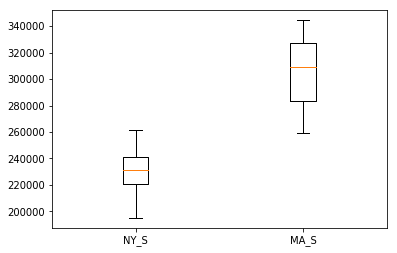

In [48]:
plt.boxplot([df_final.NY_S, df_final.MA_S])
plt.xticks([1,2], ['NY_S','MA_S'])
plt.show()

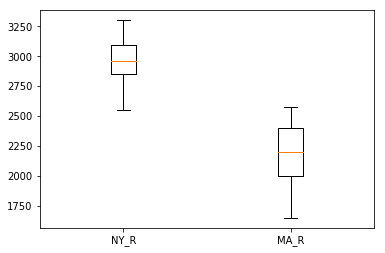

In [49]:
plt.boxplot([df_final.NY_R, df_final.MA_R])
plt.xticks([1,2], ['NY_R','MA_R'])
plt.show()

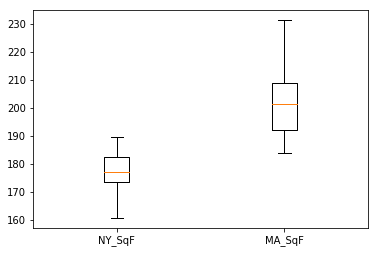

In [50]:
plt.boxplot([df_final.NY_SqF, df_final.MA_SqF])
plt.xticks([1,2], ['NY_SqF','MA_SqF'])
plt.show()

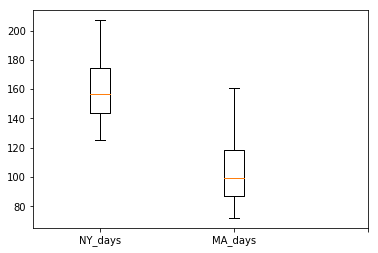

In [51]:
plt.boxplot([df_final.NY_days, df_final.MA_days])
plt.xticks([1,2,3], ['NY_days','MA_days'])
plt.show()

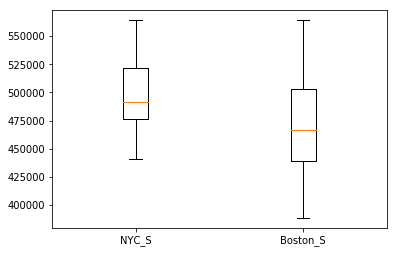

In [52]:
plt.boxplot([df_final.NYC_S, df_final.Boston_S])
plt.xticks([1,2], ['NYC_S','Boston_S'])
plt.show()

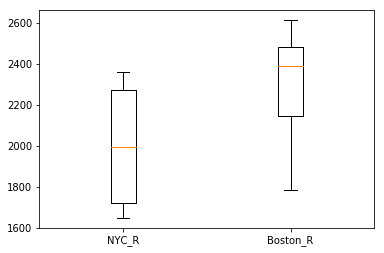

In [53]:
plt.boxplot([df_final.NYC_R, df_final.Boston_R])
plt.xticks([1,2], ['NYC_R','Boston_R'])
plt.show()

### And some EDA

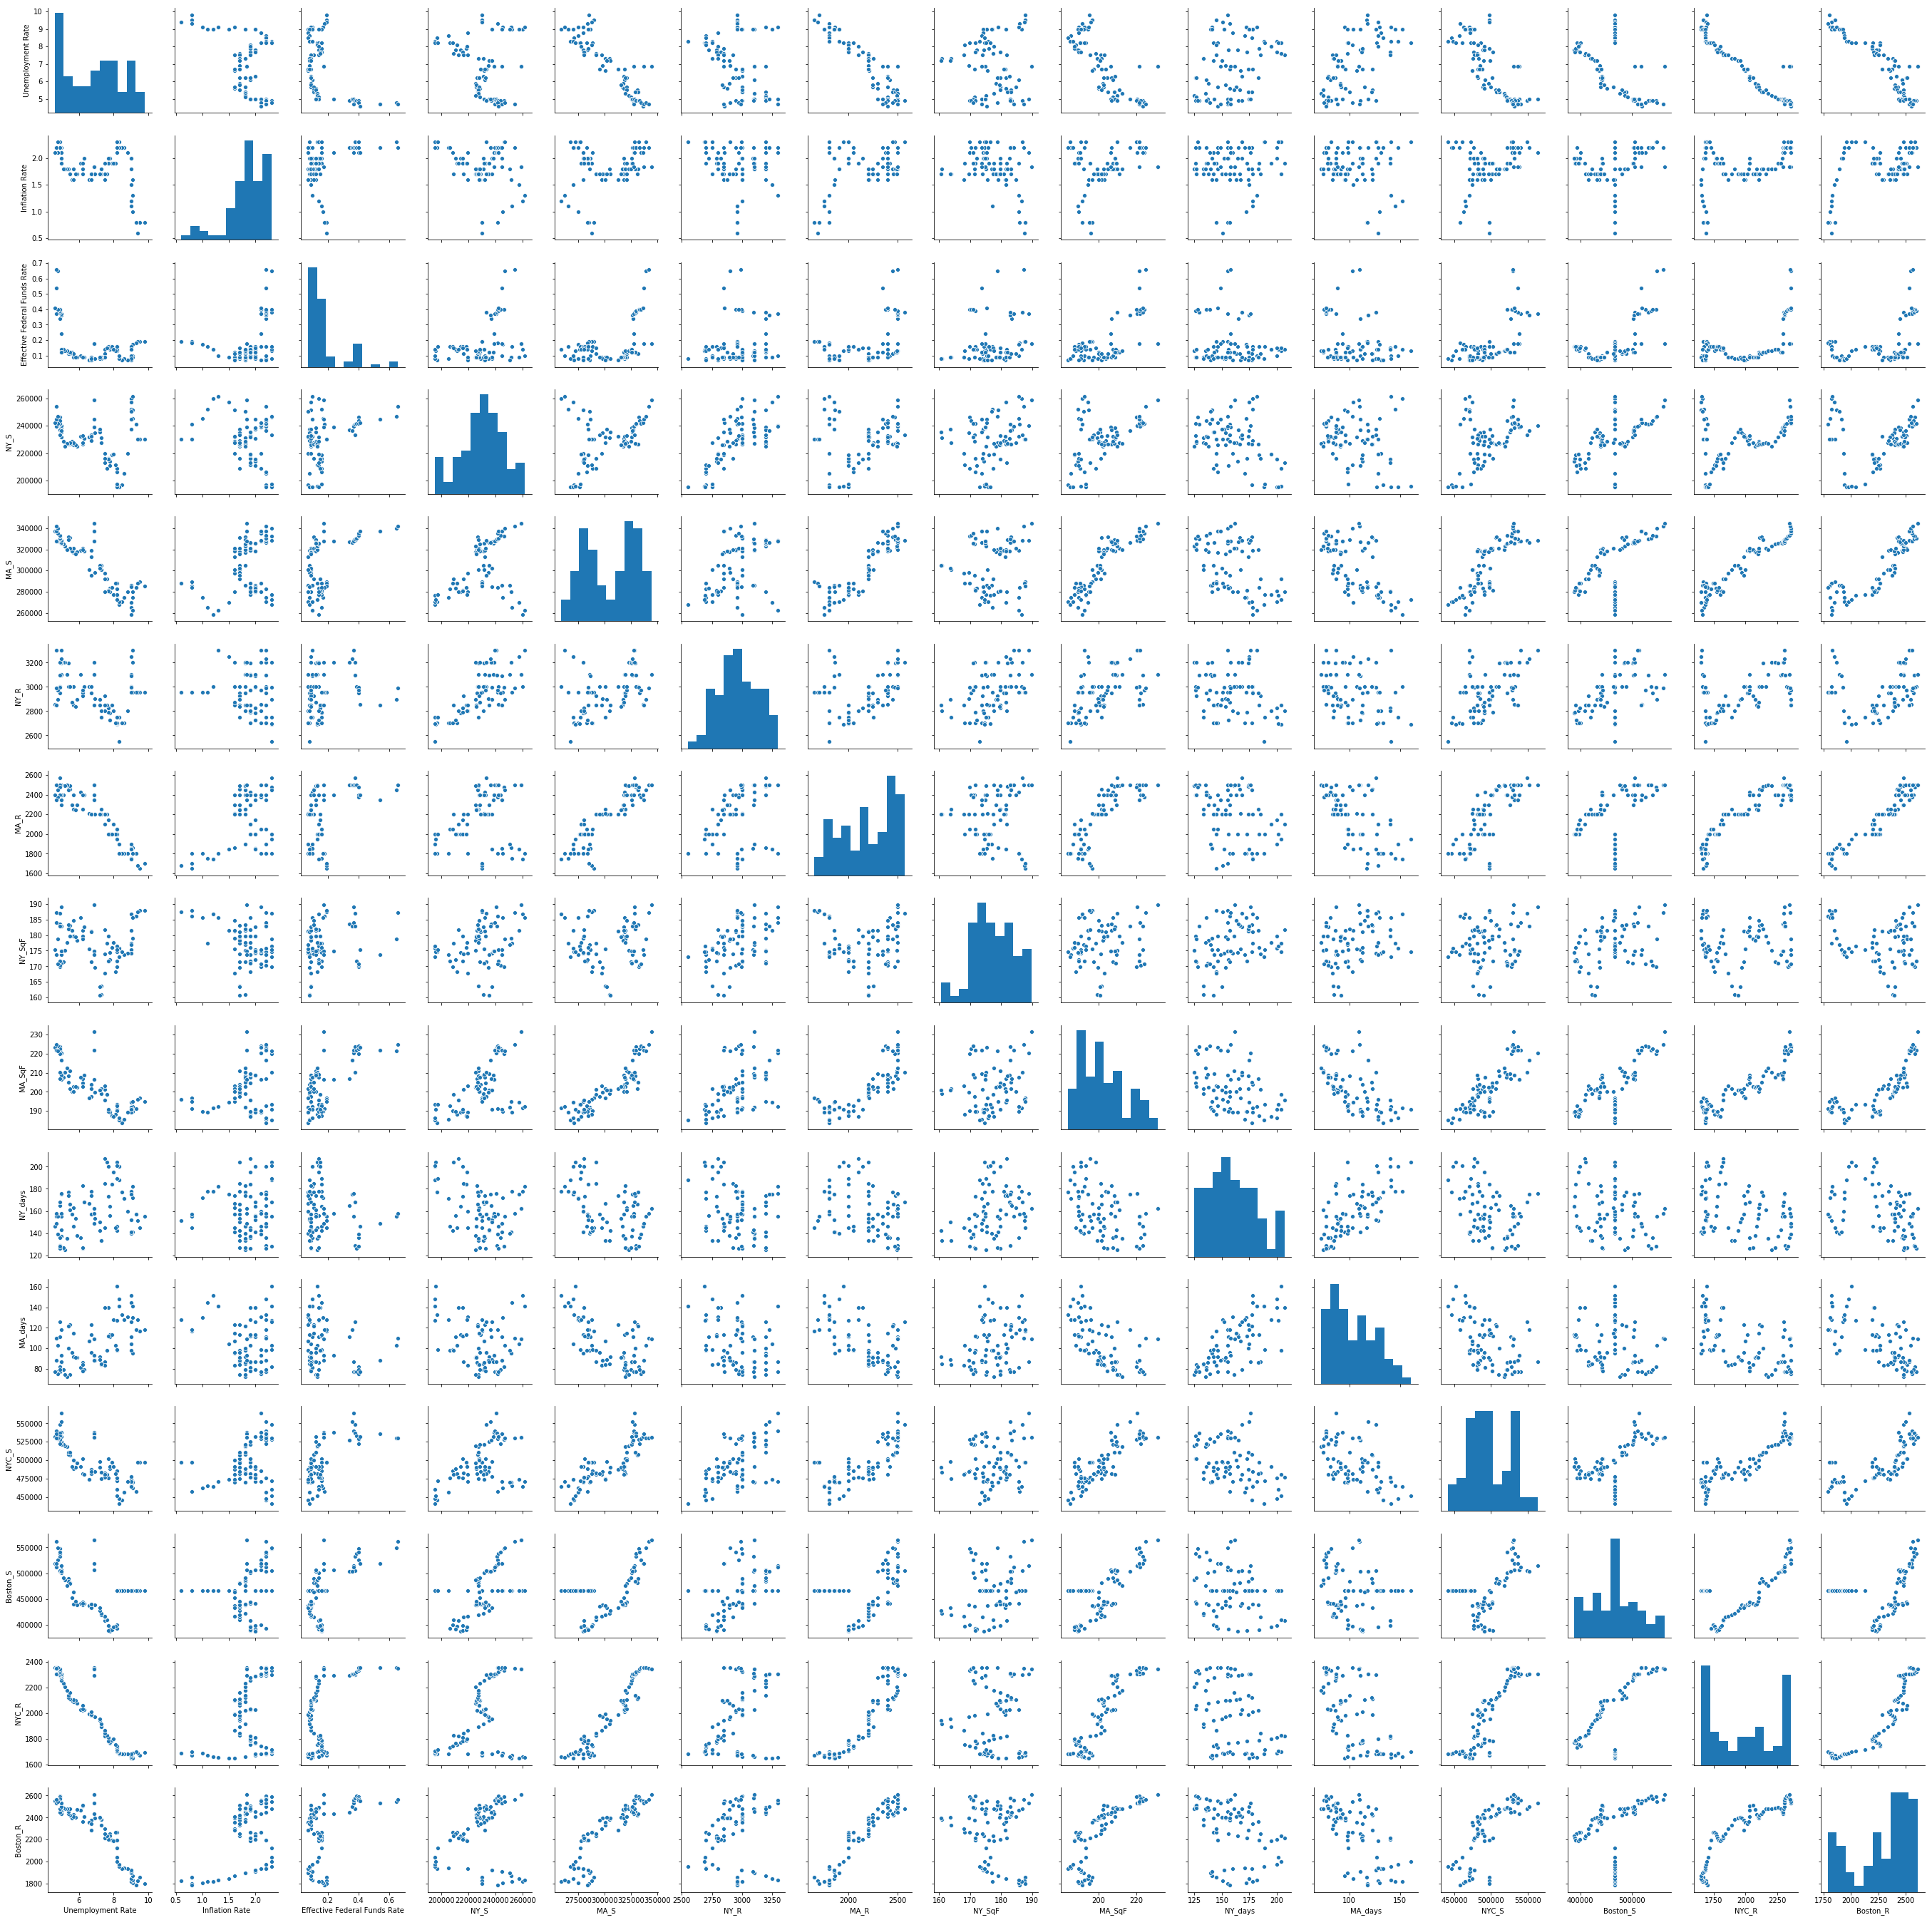

In [54]:
sns.pairplot(df_final, size=2.5);



In [55]:
df_final.describe()

,Unemployment Rate,Inflation Rate,Effective Federal Funds Rate,NY_S,MA_S,NY_R,MA_R,NY_SqF,MA_SqF,NY_days,MA_days,NYC_S,Boston_S,NYC_R,Boston_R
count,82.000000,82.000000,82.000000,82.000000,82.000000,82.000000,82.000000,82.000000,82.000000,82.000000,82.000000,82.000000,82.000000,82.000000,82.000000
mean,6.862821,1.835897,0.175000,230164.556962,305284.146341,2957.815789,2189.920732,177.459070,202.679372,159.524390,104.018293,497241.772152,466878.688525,1988.812593,2286.367037
std,1.567266,0.370510,0.129584,16100.839929,24098.693523,170.755381,262.012763,6.599151,12.106396,21.026864,21.732158,28010.983770,44732.988669,255.688948,253.994432
min,4.600000,0.600000,0.070000,195000.000000,258900.000000,2550.000000,1650.000000,160.656535,183.888889,125.000000,72.000000,440700.000000,388400.000000,1648.890000,1787.040000
25%,5.325000,1.700000,0.090000,220900.000000,283600.000000,2850.000000,2000.000000,173.677579,192.212702,143.500000,87.000000,476450.000000,438700.000000,1719.930000,2143.650000
50%,6.862821,1.867949,0.130000,231100.000000,309000.000000,2957.815789,2204.500000,177.150933,201.405712,157.000000,99.000000,491150.000000,466878.688525,1992.236296,2387.795000
75%,8.200000,2.100000,0.175000,240925.000000,326975.000000,3095.000000,2400.000000,182.482252,208.986638,174.750000,118.375000,521800.000000,502775.000000,2272.137500,2481.315000
max,9.800000,2.300000,0.660000,261700.000000,344400.000000,3300.000000,2575.000000,189.710706,231.395797,207.000000,161.000000,564000.000000,564100.000000,2358.660000,2610.660000


In [56]:
df_final.corr()

,Unemployment Rate,Inflation Rate,Effective Federal Funds Rate,NY_S,MA_S,NY_R,MA_R,NY_SqF,MA_SqF,NY_days,MA_days,NYC_S,Boston_S,NYC_R,Boston_R
Unemployment Rate,1.000000,-0.465729,-0.513815,-0.223187,-0.885364,-0.382878,-0.927932,-0.006802,-0.784115,0.331988,0.594896,-0.777566,-0.506823,-0.932145,-0.911488
Inflation Rate,-0.465729,1.000000,0.351506,-0.293638,0.282366,-0.147310,0.441984,-0.318181,0.273631,0.043859,-0.167989,0.260092,0.224328,0.371492,0.470482
Effective Federal Funds Rate,-0.513815,0.351506,1.000000,0.355007,0.496549,0.198507,0.413851,0.175786,0.637688,-0.151062,-0.177756,0.642981,0.632150,0.577823,0.406775
NY_S,-0.223187,-0.293638,0.355007,1.000000,0.410782,0.689220,0.246417,0.308870,0.538764,-0.387103,-0.241601,0.460377,0.558031,0.410769,0.184704
MA_S,-0.885364,0.282366,0.496549,0.410782,1.000000,0.450183,0.904747,0.132261,0.902262,-0.457423,-0.629973,0.846443,0.630835,0.956817,0.891185
NY_R,-0.382878,-0.147310,0.198507,0.689220,0.450183,1.000000,0.417331,0.443796,0.479850,-0.238987,-0.284658,0.567690,0.510151,0.463671,0.252002
MA_R,-0.927932,0.441984,0.413851,0.246417,0.904747,0.417331,1.000000,0.040824,0.815870,-0.314411,-0.625861,0.778611,0.456233,0.917252,0.954609
NY_SqF,-0.006802,-0.318181,0.175786,0.308870,0.132261,0.443796,0.040824,1.000000,0.186700,0.291786,0.303988,0.169506,0.311981,0.086093,-0.112791
MA_SqF,-0.784115,0.273631,0.637688,0.538764,0.902262,0.479850,0.815870,0.186700,1.000000,-0.395034,-0.594472,0.839254,0.755522,0.912083,0.801234
NY_days,0.331988,0.043859,-0.151062,-0.387103,-0.457423,-0.238987,-0.314411,0.291786,-0.395034,1.000000,0.696856,-0.388176,-0.246556,-0.379635,-0.385240


### Let's take a look at the distribution of each of our variables which we've already selected prior because we knew we wanted to focus on MA and NY for all these data points.

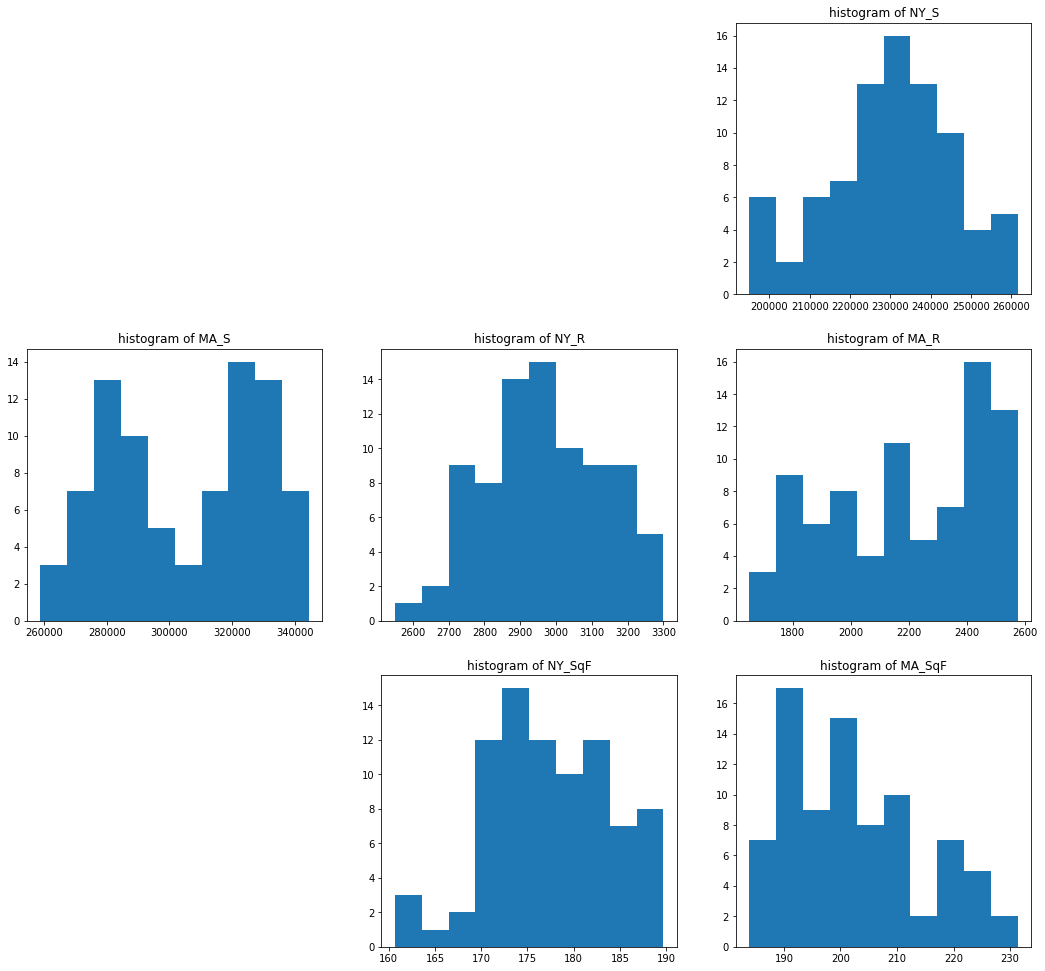

In [57]:
plt.figure(figsize=(18,17))

# histograms of the original data

plt.subplot(3, 3, 3)
plt.hist(df_final["NY_S"])
plt.title("histogram of NY_S")

plt.subplot(3, 3, 4)
plt.hist(df_final["MA_S"])
plt.title("histogram of MA_S")

plt.subplot(3, 3, 5)
plt.hist(df_final["NY_R"])
plt.title("histogram of NY_R")

plt.subplot(3, 3, 6)
plt.hist(df_final["MA_R"])
plt.title("histogram of MA_R")

plt.subplot(3, 3, 8)
plt.hist(df_final["NY_SqF"])
plt.title("histogram of NY_SqF")

plt.subplot(3, 3, 9)
plt.hist(df_final["MA_SqF"])
plt.title("histogram of MA_SqF")

plt.show()

Text(0.5, 1.0, 'histogram of Boston_R')

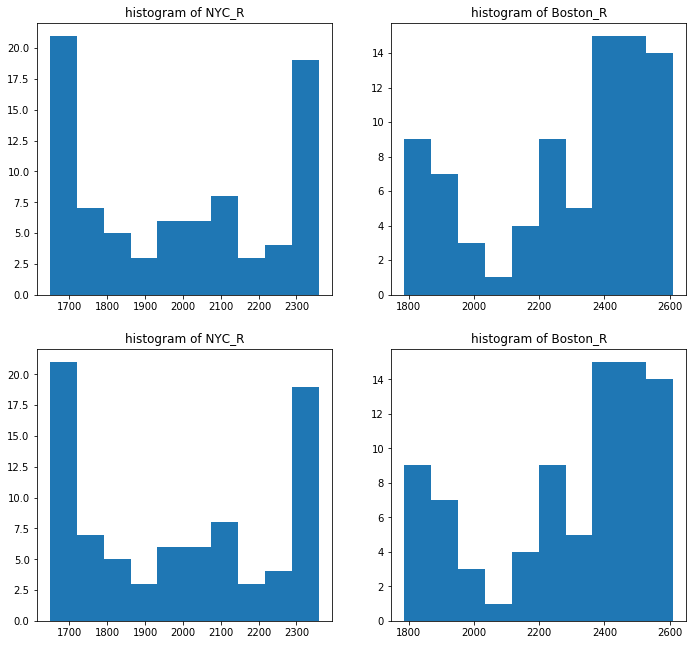

In [58]:
plt.figure(figsize=(18,17))

plt.subplot(3, 3, 5)
plt.hist(df_final["NYC_R"])
plt.title("histogram of NYC_R")

plt.subplot(3, 3, 6)
plt.hist(df_final["Boston_R"])
plt.title("histogram of Boston_R")

plt.subplot(3, 3, 8)
plt.hist(df_final["NYC_R"])
plt.title("histogram of NYC_R")

plt.subplot(3, 3, 9)
plt.hist(df_final["Boston_R"])
plt.title("histogram of Boston_R")

# 3. Supervised Modeling! 

### We have looked over out data, normalized it, accounted for ouliers and created a DF with exactly the variables we want to isolate. Because I knew which features I wanted to include in my model, this made feature selection easy. 

### Let's put those features to work for us by loading them into a regression model. This will be the supervised portion of this project where we will use regression to better help us with predicting NYC and Boston sale prices for us in the future. 

### Let's start with OLS to get a baseline regression going to predict NYC Sale prices since that's where I currently live, and then move on to Boston and then get the same values for our Huber regressor.





# Before we do anything, lets create a function for our model!

## Our function will take five arguments: 
### 1.  Features (X)
### 2.  Y (Target)
### 3.  Model parameters
### 4.  Chosen split criteria   
### 5.  Model type 

## We will scale our features and use GridSearchCV to best test our parameters so that they aren't manually (and suboptimally) tested.

## Then, we will use the results from our GridSearch "Best Estimator" to input the parameters that gave us the best score with GridSearch. 


In [303]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import HuberRegressor
from sklearn.model_selection import GridSearchCV


def model_function(features, Y, parameters, split_criteria, model):  #arguement 
    print('split_criteria = {}'.format(split_criteria))
    X = StandardScaler().fit_transform(features)
    grid = GridSearchCV(model,parameters, cv=7)
    grid.fit(X, Y)
    reg = grid.best_estimator_
    if split_criteria<1:
        print('entered split criteria and < 1')
        X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = split_criteria, random_state = 465) #split from before
    elif split_criteria>1:
        X = pd.DataFrame(X, columns=features.columns) #pd.df to make sure X can work as a df for split by row
        print('entered elif split > 1')
        X_train = X.iloc[:split_criteria, :]
        X_test = X.iloc[split_criteria:, :]
        Y_train = Y.iloc[:split_criteria]
        Y_test = Y.iloc[split_criteria:]

    
    reg.fit(X_train, Y_train)
  
    y_preds_train = reg.predict(X_train)
    y_preds_test = reg.predict(X_test)

    print("The number of observations in training set is {}".format(X_train.shape[0]))
    print("The number of observations in test set is {}".format(X_test.shape[0]))
    
    print("R-squared of the model in the training set is: {}".format(reg.score(X_train, Y_train)))
    
    print("-----Test set statistics-----")
    
    print("R-squared of the model in the test set is: {}".format(reg.score(X_test, Y_test)))
    print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(Y_test, y_preds_test)))
    print("Mean squared error of the prediction is: {}".format(mse(Y_test, y_preds_test)))
    print("Root mean squared error of the prediction is: {}".format(rmse(Y_test, y_preds_test)))
    print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((Y_test - y_preds_test) / Y_test)) * 100))


    print('coefficients: ' + str(reg.coef_))
    print('intercept: ' + str(reg.intercept_))
    print('score: ' + str(reg.score(X,Y)))
   










#def name (argument1, argument2)
#create function implementation
#return output 


# ORDINARY LEAST SQUARES

### OLS Regression for NYC Sale and Rental Markets:





In [281]:
model_function(
    df_final[['NY_S', 'NYC_R', 'NY_SqF', 'NY_days']], 
    df_final['NYC_S'], 
    {'fit_intercept':[True,False], 'normalize':[True,False], 'copy_X':[True, False]}, #parameters = {'alpha': [1,2], 'hyper': [100,200,300,400,500], 'fit_intercept': [True,False]} OR {'epsilon':[1, 3, 5], 'alpha':[.0001, .10, 1, 103], 'warm_start':[True, False]}, 
    .2, 
    LinearRegression()
)




The number of observations in training set is 65
The number of observations in test set is 17
R-squared of the model in the training set is: 0.8139725097046036
-----Test set statistics-----
R-squared of the model in the test set is: 0.6846940959750036
Mean absolute error of the prediction is: 11642.092239657872
Mean squared error of the prediction is: 178528690.1941309
Root mean squared error of the prediction is: 13361.462876277092
Mean absolute percentage error of the prediction is: 2.417047372659312
coefficients: [ 1295.82039794 23135.57118305  3135.65671981 -2093.51081492]
intercept: 497421.1368789797
score: 0.8059701972597173


In [282]:
model_function(
    df_final[['NY_S', 'NYC_S', 'NY_SqF', 'NY_days']], 
    df_final['NYC_R'], 
    {'fit_intercept':[True,False], 'normalize':[True,False], 'copy_X':[True, False]}, #parameters = {'alpha': [1,2], 'hyper': [100,200,300,400,500], 'fit_intercept': [True,False]} OR {'epsilon':[1, 3, 5], 'alpha':[.0001, .10, 1, 103], 'warm_start':[True, False]}, 
    .2, 
    LinearRegression()
)



The number of observations in training set is 65
The number of observations in test set is 17
R-squared of the model in the training set is: 0.8042516361737233
-----Test set statistics-----
R-squared of the model in the test set is: 0.6086731111436587
Mean absolute error of the prediction is: 109.21854611048342
Mean squared error of the prediction is: 17304.666146466654
Root mean squared error of the prediction is: 131.54720121107349
Mean absolute percentage error of the prediction is: 6.098752977142201
coefficients: [  4.37828959 223.46435564 -12.95780329 -12.34913493]
intercept: 1993.7625479200713
score: 0.7896674401991808


### OLS Regression for Boston Sale and Rental Markets:




In [283]:
model_function(
    df_final[['MA_S', 'Boston_R', 'MA_SqF', 'MA_days']], 
    df_final['Boston_S'], 
    {'fit_intercept':[True,False], 'normalize':[True,False], 'copy_X':[True, False]}, #parameters = {'alpha': [1,2], 'hyper': [100,200,300,400,500], 'fit_intercept': [True,False]} OR {'epsilon':[1, 3, 5], 'alpha':[.0001, .10, 1, 103], 'warm_start':[True, False]}, 
    .2, 
    LinearRegression()
)


The number of observations in training set is 65
The number of observations in test set is 17
R-squared of the model in the training set is: 0.8100387245494819
-----Test set statistics-----
R-squared of the model in the test set is: 0.534781533551802
Mean absolute error of the prediction is: 20449.707469661917
Mean squared error of the prediction is: 604339308.2846049
Root mean squared error of the prediction is: 24583.313614820214
Mean absolute percentage error of the prediction is: 4.562875815181129
coefficients: [ 27170.22650645 -36400.70894071  44419.56723241   8883.75231036]
intercept: 468430.35291073995
score: 0.780801143583296


In [284]:
model_function(
    df_final[['MA_S', 'Boston_S', 'MA_SqF', 'MA_days']], 
    df_final['Boston_R'], 
    {'fit_intercept':[True,False], 'normalize':[True,False], 'copy_X':[True, False]}, #parameters = {'alpha': [1,2], 'hyper': [100,200,300,400,500], 'fit_intercept': [True,False]} OR {'epsilon':[1, 3, 5], 'alpha':[.0001, .10, 1, 103], 'warm_start':[True, False]}, 
    .2, 
    LinearRegression()
)



The number of observations in training set is 65
The number of observations in test set is 17
R-squared of the model in the training set is: 0.9006597058071824
-----Test set statistics-----
R-squared of the model in the test set is: 0.7256360575760475
Mean absolute error of the prediction is: 102.61322887253614
Mean squared error of the prediction is: 14947.211900290764
Root mean squared error of the prediction is: 122.2587906871762
Mean absolute percentage error of the prediction is: 5.027563570256679
coefficients: [ 194.46561013 -101.30640405   96.9580018   -16.75110699]
intercept: 2293.716449743827
score: 0.8750008991495227


### We will now create a 2 year forecast. We started with 83 rows. We will go back to the 58th row and set that as our benchmark, since each row is one month in time. This will allow for 58 rows of training and 24 rows (2 years) for testing.

### Let's predict first two years with OLS for Boston Rent and Sale, as well as NYC Rent and Sale forecasts:

In [314]:
model_function(
    df_final[['NY_S', 'NYC_S', 'NY_SqF', 'NY_days', 'MA_S', 'Boston_S', 'MA_R', 'Boston_R', 'MA_SqF', 'MA_days']], 
    df_final['NYC_R'], 
    {'fit_intercept':[True,False], 'normalize':[True,False], 'copy_X':[True, False]}, #parameters = {'alpha': [1,2], 'hyper': [100,200,300,400,500], 'fit_intercept': [True,False]} OR {'epsilon':[1, 3, 5], 'alpha':[.0001, .10, 1, 103], 'warm_start':[True, False]}, 
    58, 
    LinearRegression()
)



split_criteria = 58
entered elif split > 1
The number of observations in training set is 58
The number of observations in test set is 24
R-squared of the model in the training set is: 0.9695536378736195
-----Test set statistics-----
R-squared of the model in the test set is: -4.337556703202593
Mean absolute error of the prediction is: 87.02236157673656
Mean squared error of the prediction is: 8782.599618971793
Root mean squared error of the prediction is: 93.71552496236572
Mean absolute percentage error of the prediction is: 3.7747989826944184
coefficients: [ 20.50459615  -2.91234198  15.9964545   12.72383726  57.22674928
  49.92552675 -20.51414885 170.05762601   8.37875387   8.79797212]
intercept: 1969.7493268594676
score: 0.9504186438983836


In [286]:
model_function(
    df_final[[ 'NY_S', 'NYC_R', 'NY_SqF', 'NY_days' ]], 
    df_final['NYC_S'], 
    {'fit_intercept':[True,False], 'normalize':[True,False], 'copy_X':[True, False]}, #parameters = {'alpha': [1,2], 'hyper': [100,200,300,400,500], 'fit_intercept': [True,False]} OR {'epsilon':[1, 3, 5], 'alpha':[.0001, .10, 1, 103], 'warm_start':[True, False]}, 
    58, 
    LinearRegression()
)



The number of observations in training set is 58
The number of observations in test set is 24
R-squared of the model in the training set is: 0.5454449920726394
-----Test set statistics-----
R-squared of the model in the test set is: -4.141370089123244
Mean absolute error of the prediction is: 20194.302554733797
Mean squared error of the prediction is: 528809104.54426247
Root mean squared error of the prediction is: 22995.8497243364
Mean absolute percentage error of the prediction is: 3.7501230159478123
coefficients: [ 1.06274021e-02  5.96594461e+01  4.05304429e+02 -2.16156916e+02]
intercept: 332791.0888748993
score: -34.87887887938192


In [287]:
model_function(
    df_final[['NY_S', 'NYC_S', 'NY_SqF', 'NY_days', 'NYC_R','MA_S', 'Boston_S', 'MA_SqF', 'MA_days']], 
    df_final['Boston_R'], 
    {'fit_intercept':[True,False], 'normalize':[True,False], 'copy_X':[True, False]}, #parameters = {'alpha': [1,2], 'hyper': [100,200,300,400,500], 'fit_intercept': [True,False]} OR {'epsilon':[1, 3, 5], 'alpha':[.0001, .10, 1, 103], 'warm_start':[True, False]}, 
    58, 
    LinearRegression()
)



The number of observations in training set is 58
The number of observations in test set is 24
R-squared of the model in the training set is: 0.9695419452152408
-----Test set statistics-----
R-squared of the model in the test set is: -2.9110634619075775
Mean absolute error of the prediction is: 94.05458795832625
Mean squared error of the prediction is: 11386.732869702859
Root mean squared error of the prediction is: 106.70863540362073
Mean absolute percentage error of the prediction is: 3.7423654643548105
coefficients: [-1.77922864e-03  3.40685348e-04 -5.49291184e+00  1.29124476e-03
  1.11206519e+00  2.84844387e-04 -1.88553090e-03  1.53648501e+00
 -5.95473684e-01]
intercept: 1851.124656018344
score: -2.947376588620993


In [288]:
model_function(
    df_final[['NY_S', 'NYC_S', 'NY_SqF', 'NY_days', 'NYC_R','MA_S', 'Boston_R', 'MA_SqF', 'MA_days']], 
    df_final['Boston_S'], 
    {'fit_intercept':[True,False], 'normalize':[True,False], 'copy_X':[True, False]}, #parameters = {'alpha': [1,2], 'hyper': [100,200,300,400,500], 'fit_intercept': [True,False]} OR {'epsilon':[1, 3, 5], 'alpha':[.0001, .10, 1, 103], 'warm_start':[True, False]}, 
    58, 
    LinearRegression()
)



The number of observations in training set is 58
The number of observations in test set is 24
R-squared of the model in the training set is: 0.7221394618695048
-----Test set statistics-----
R-squared of the model in the test set is: -0.6494229665281486
Mean absolute error of the prediction is: 21257.79667567607
Mean squared error of the prediction is: 822525969.1976091
Root mean squared error of the prediction is: 28679.71354803965
Mean absolute percentage error of the prediction is: 3.9525196504375777
coefficients: [-3.73044181e-01 -3.30616975e-01 -7.32961196e+02 -2.09694106e+02
  2.58694091e+02  3.13576850e-01 -2.53039274e+02  1.76841711e+03
  2.50139325e+02]
intercept: 458344.58102577477
score: 0.015280992448868158


### Now let's predict first four years with OLS for Boston Rent and Sale, as well as NYC Rent and Sale forecasts:

In [289]:
model_function(
    df_final[['MA_S', 'Boston_R', 'MA_SqF', 'MA_days', 'Unemployment Rate', 'Inflation Rate', 'Effective Federal Funds Rate']], 
    df_final['Boston_S'], 
    {'fit_intercept':[True,False], 'normalize':[True,False], 'copy_X':[True, False]}, #parameters = {'alpha': [1,2], 'hyper': [100,200,300,400,500], 'fit_intercept': [True,False]} OR {'epsilon':[1, 3, 5], 'alpha':[.0001, .10, 1, 103], 'warm_start':[True, False]}, 
    34, 
    LinearRegression()
)


The number of observations in training set is 34
The number of observations in test set is 48
R-squared of the model in the training set is: 0.9175783982660675
-----Test set statistics-----
R-squared of the model in the test set is: -2.558490639498844
Mean absolute error of the prediction is: 74740.41331480969
Mean squared error of the prediction is: 6443453013.668519
Root mean squared error of the prediction is: 80271.12191609458
Mean absolute percentage error of the prediction is: 15.061301854126445
coefficients: [ 3.23865655e-01 -2.57434231e+02  2.24931405e+03  6.80837575e+01
 -7.77427330e+03  3.33644711e+04  1.98688384e+04]
intercept: 438497.4260007179
score: -0.5453279357258485


In [290]:
model_function(
    df_final[[ 'MA_S', 'Boston_S', 'NY_S', 'NYC_S', 'NY_SqF', 'NY_days','MA_SqF', 'MA_days', 'Unemployment Rate', 'Inflation Rate', 'Effective Federal Funds Rate']], 
    df_final['Boston_R'], 
    {'fit_intercept':[True,False], 'normalize':[True,False], 'copy_X':[True, False]}, #parameters = {'alpha': [1,2], 'hyper': [100,200,300,400,500], 'fit_intercept': [True,False]} OR {'epsilon':[1, 3, 5], 'alpha':[.0001, .10, 1, 103], 'warm_start':[True, False]}, 
    34,
    LinearRegression()
)


The number of observations in training set is 34
The number of observations in test set is 48
R-squared of the model in the training set is: 0.983415926816146
-----Test set statistics-----
R-squared of the model in the test set is: -1.1034236855018995
Mean absolute error of the prediction is: 81.11674030381256
Mean squared error of the prediction is: 12949.575103155175
Root mean squared error of the prediction is: 113.79619986254012
Mean absolute percentage error of the prediction is: 3.2429827961892173
coefficients: [ 3.00485552e-04 -1.80729008e-03 -8.54003750e-04  9.64963856e-04
 -2.74103953e+00 -4.41731812e-01  4.54253462e+00 -3.54678773e-01
 -1.20574911e+02  5.44728574e+01  3.05306550e+02]
intercept: 3093.277207551201
score: -10.77870494147552


In [291]:
model_function(
    df_final[[ 'NY_S', 'NYC_S', 'NY_SqF', 'NY_days', 'Unemployment Rate', 'Inflation Rate', 'Effective Federal Funds Rate']], 
    df_final['NYC_R'], 
    {'fit_intercept':[True,False], 'normalize':[True,False], 'copy_X':[True, False]}, #parameters = {'alpha': [1,2], 'hyper': [100,200,300,400,500], 'fit_intercept': [True,False]} OR {'epsilon':[1, 3, 5], 'alpha':[.0001, .10, 1, 103], 'warm_start':[True, False]}, 
    34, 
    LinearRegression()
)


The number of observations in training set is 34
The number of observations in test set is 48
R-squared of the model in the training set is: 0.9171017897166149
-----Test set statistics-----
R-squared of the model in the test set is: -0.8367722764058589
Mean absolute error of the prediction is: 163.71799604010758
Mean squared error of the prediction is: 40384.247181402156
Root mean squared error of the prediction is: 200.95832200086204
Mean absolute percentage error of the prediction is: 7.24680448757042
coefficients: [-5.02740438e-04  8.24007228e-04  6.91823857e-01 -1.94093927e-01
 -1.03413752e+02 -6.07701581e+01 -1.59288024e+02]
intercept: 2356.305379483258
score: -2.60176969876141


In [292]:
model_function(
    df_final[['NY_S', 'NYC_R', 'NY_SqF', 'NY_days', 'MA_days', 'Boston_S']], 
    df_final['NYC_S'], 
    {'fit_intercept':[True,False], 'normalize':[True,False], 'copy_X':[True, False]}, #parameters = {'alpha': [1,2], 'hyper': [100,200,300,400,500], 'fit_intercept': [True,False]} OR {'epsilon':[1, 3, 5], 'alpha':[.0001, .10, 1, 103], 'warm_start':[True, False]}, 
    34, 
    LinearRegression()
)

The number of observations in training set is 34
The number of observations in test set is 48
R-squared of the model in the training set is: 0.6640234111130966
-----Test set statistics-----
R-squared of the model in the test set is: -1.9318867572093643
Mean absolute error of the prediction is: 32307.767529126464
Mean squared error of the prediction is: 1539802441.5959027
Root mean squared error of the prediction is: 39240.31653281995
Mean absolute percentage error of the prediction is: 6.126576606148682
coefficients: [-5.79210246e-03  3.51580010e+01  1.45081028e+03 -2.46722501e+02
 -1.46735008e+02 -3.08715472e-01]
intercept: 353817.9219855226
score: -26.511005563358015


# Now let's try a robust regressor for comparison. I chose Huber as my robust regressor. Just as with OLS, we will first do an 80/20 split, then a 2 year and end with a 4 year prediction.



### Huber Regression for NYC Sale and Rental Markets:


In [304]:
model_function(
    df_final[['NY_S', 'NYC_R', 'NY_SqF', 'NY_days']], 
    df_final['NYC_S'], 
    {'epsilon':[1, 3, 5], 'alpha':[.0001, .10, 1, 103], 'warm_start':[True, False]}, #parameters = {'alpha': [1,2], 'hyper': [100,200,300,400,500], 'fit_intercept': [True,False]} OR {'epsilon':[1, 3, 5], 'alpha':[.0001, .10, 1, 103], 'warm_start':[True, False]}, 
    .2, 
    HuberRegressor() 
)

#R2 Train: 0.594
#R2 Test: 0.265



split_criteria = 0.2
entered split criteria and < 1
The number of observations in training set is 65
The number of observations in test set is 17
R-squared of the model in the training set is: 0.8051410868739948
-----Test set statistics-----
R-squared of the model in the test set is: 0.6825164274443586
Mean absolute error of the prediction is: 11889.457804768215
Mean squared error of the prediction is: 179761703.2950281
Root mean squared error of the prediction is: 13407.524129943906
Mean absolute percentage error of the prediction is: 2.4693305746540566
coefficients: [  255.12348208 22402.78003471  1590.61588687 -2522.79068647]
intercept: 496665.137118525
score: 0.7986961461804511


In [294]:
model_function(
    df_final[['NY_S', 'NYC_S', 'NY_SqF', 'NY_days']], 
    df_final['NYC_R'], 
    {'epsilon':[1, 3, 5], 'alpha':[.0001, .10, 1, 103], 'warm_start':[True, False]}, #parameters = {'alpha': [1,2], 'hyper': [100,200,300,400,500], 'fit_intercept': [True,False]} OR {'epsilon':[1, 3, 5], 'alpha':[.0001, .10, 1, 103], 'warm_start':[True, False]}, 
    .2,
    HuberRegressor()
)

#R2 Train: 0.595
#R2 Test: 0.152


The number of observations in training set is 65
The number of observations in test set is 17
R-squared of the model in the training set is: 0.8042516069174196
-----Test set statistics-----
R-squared of the model in the test set is: 0.6086483529155968
Mean absolute error of the prediction is: 109.20762469419316
Mean squared error of the prediction is: 17305.76096740329
Root mean squared error of the prediction is: 131.55136246882162
Mean absolute percentage error of the prediction is: 6.098211023555562
coefficients: [  4.38604841 223.41218678 -12.9399179  -12.37221778]
intercept: 1993.7675307618683
score: 0.7896639024078527


### Huber Regression for Boston Sale and Rental Markets:


In [315]:

model_function(
    df_final[['MA_S', 'Boston_R', 'MA_SqF', 'MA_days']], 
    df_final['Boston_S'], 
    {'epsilon':[1, 3, 5], 'alpha':[.0001, .10, 1, 103], 'warm_start':[True, False]}, #parameters = {'alpha': [1,2], 'hyper': [100,200,300,400,500], 'fit_intercept': [True,False]} OR {'epsilon':[1, 3, 5], 'alpha':[.0001, .10, 1, 103], 'warm_start':[True, False]}, 
    .2,
    HuberRegressor()
)

#R2 Train: 0.596
#R2 Test: 0.246


split_criteria = 0.2
entered split criteria and < 1
The number of observations in training set is 65
The number of observations in test set is 17
R-squared of the model in the training set is: -0.01096427513142495
-----Test set statistics-----
R-squared of the model in the test set is: -0.25316880948227727
Mean absolute error of the prediction is: 28998.72085500693
Mean squared error of the prediction is: 1627921559.66726
Root mean squared error of the prediction is: 40347.50995621985
Mean absolute percentage error of the prediction is: 6.8368528460871385
coefficients: [ 0.31335193  0.23249644  0.38048905 -0.02822387]
intercept: 466879.9726982594
score: 2.5972775158811245e-05


In [316]:
model_function(
    df_final[['MA_S', 'Boston_S', 'MA_SqF', 'MA_days']], 
    df_final['Boston_R'], 
    {'epsilon':[1, 3, 5], 'alpha':[.0001, .10, 1, 103],'warm_start':[True, False]}, #parameters = {'alpha': [1,2], 'hyper': [100,200,300,400,500], 'fit_intercept': [True,False]} OR {'epsilon':[1, 3, 5], 'alpha':[.0001, .10, 1, 103], 'warm_start':[True, False]}, 
    .2, 
    HuberRegressor()
)

#R2 Train: 0.879
#R2 Test: 0.680

split_criteria = 0.2
entered split criteria and < 1
The number of observations in training set is 65
The number of observations in test set is 17
R-squared of the model in the training set is: 0.900659658960542
-----Test set statistics-----
R-squared of the model in the test set is: 0.7256008691919129
Mean absolute error of the prediction is: 102.61219992413746
Mean squared error of the prediction is: 14949.12894605649
Root mean squared error of the prediction is: 122.26663055002575
Mean absolute percentage error of the prediction is: 5.027637502192743
coefficients: [ 194.39660578 -101.22959162   96.92139885  -16.79817182]
intercept: 2293.7171831079636
score: 0.8749946265326304



### Now let's predict first two years with Huber for Boston Rent and Sale, as well as NYC Rent and Sale forecasts:

In [317]:
model_function(
    df_final[['NY_S', 'NYC_S', 'NY_SqF', 'NY_days', 'Unemployment Rate', 'Inflation Rate', 'Effective Federal Funds Rate']], 
    df_final['NYC_R'], 
    {'epsilon':[1, 3, 5], 'alpha':[.0001, .10, 1, 103],'warm_start':[True, False]}, #parameters = {'alpha': [1,2], 'hyper': [100,200,300,400,500], 'fit_intercept': [True,False]} OR {'epsilon':[1, 3, 5], 'alpha':[.0001, .10, 1, 103], 'warm_start':[True, False]}, 
    58, 
    HuberRegressor()
)

#R2 Train:0.356 
#R2 Test: -50.1


split_criteria = 58
entered elif split > 1
The number of observations in training set is 58
The number of observations in test set is 24
R-squared of the model in the training set is: 0.9837455382089635
-----Test set statistics-----
R-squared of the model in the test set is: -40.83685411411323
Mean absolute error of the prediction is: 234.47713578302572
Mean squared error of the prediction is: 68839.80057413226
Root mean squared error of the prediction is: 262.37339913591137
Mean absolute percentage error of the prediction is: 10.064775538326202
coefficients: [  -4.86637495   33.98002105   -7.04035767   -1.99455514 -191.84815618
  -28.8285159   -59.06404569]
intercept: 1919.4510269100258
score: 0.6827891885202455


In [318]:
model_function(
    df_final[['MA_S', 'Boston_S', 'MA_SqF', 'MA_days', 'NY_S', 'NYC_S', 'NY_SqF', 'NY_days', 'Unemployment Rate', 'Inflation Rate', 'Effective Federal Funds Rate']],    
    df_final['Boston_R'], 
    {'epsilon':[1, 3, 5], 'alpha':[.0001, .10, 1, 103],'warm_start':[True, False]}, #parameters = {'alpha': [1,2], 'hyper': [100,200,300,400,500], 'fit_intercept': [True,False]} OR {'epsilon':[1, 3, 5], 'alpha':[.0001, .10, 1, 103], 'warm_start':[True, False]}, 
    58, 
    HuberRegressor()
)

#R2 Train: 0.840
#R2 Test: -2.89


split_criteria = 58
entered elif split > 1
The number of observations in training set is 58
The number of observations in test set is 24
R-squared of the model in the training set is: 0.9812245351191167
-----Test set statistics-----
R-squared of the model in the test set is: -5.371834726325031
Mean absolute error of the prediction is: 93.45393704942364
Mean squared error of the prediction is: 18551.061782866538
Root mean squared error of the prediction is: 136.20228259051513
Mean absolute percentage error of the prediction is: 3.6830271368919303
coefficients: [  26.44828044  -82.76288253   48.6035987    -2.94339505   -8.51406317
   28.30286988  -32.40329565   -9.34677904 -192.40525733   11.79146241
    7.36363593]
intercept: 2285.8487057685425
score: 0.9032719721565232


In [319]:
model_function(
    df_final[['MA_S', 'Boston_R','MA_SqF','MA_days','Unemployment Rate','Inflation Rate','Effective Federal Funds Rate']],    
    df_final['Boston_S'], 
    {'epsilon':[1, 3, 5], 'alpha':[.0001, .10, 1, 103],'warm_start':[True, False]}, #parameters = {'alpha': [1,2], 'hyper': [100,200,300,400,500], 'fit_intercept': [True,False]} OR {'epsilon':[1, 3, 5], 'alpha':[.0001, .10, 1, 103], 'warm_start':[True, False]}, 
    58, 
    HuberRegressor()
)

split_criteria = 58
entered elif split > 1
The number of observations in training set is 58
The number of observations in test set is 24
R-squared of the model in the training set is: -0.0047178814640052025
-----Test set statistics-----
R-squared of the model in the test set is: -11.553714472189544
Mean absolute error of the prediction is: 75904.84357078426
Mean squared error of the prediction is: 6260223346.47269
Root mean squared error of the prediction is: 79121.57320524339
Mean absolute percentage error of the prediction is: 14.389149100398024
coefficients: [-0.1158294  -0.30948286 -0.07057107  0.247685    0.14901569 -0.12404708
  0.02034773]
intercept: 446050.18952714244
score: -0.21949399572607328


In [320]:
model_function(
    df_final[['MA_S', 'Boston_R','MA_SqF','MA_days','Unemployment Rate','Inflation Rate','Effective Federal Funds Rate']],    
    df_final['Boston_S'], 
    {'epsilon':[1, 3, 5], 'alpha':[.0001, .10, 1, 103],'warm_start':[True, False]}, #parameters = {'alpha': [1,2], 'hyper': [100,200,300,400,500], 'fit_intercept': [True,False]} OR {'epsilon':[1, 3, 5], 'alpha':[.0001, .10, 1, 103], 'warm_start':[True, False]}, 
    58, 
    HuberRegressor()
)


#R2 Train:0.429 
#R2 Test: -6.25

split_criteria = 58
entered elif split > 1
The number of observations in training set is 58
The number of observations in test set is 24
R-squared of the model in the training set is: -0.0047178814640052025
-----Test set statistics-----
R-squared of the model in the test set is: -11.553714472189544
Mean absolute error of the prediction is: 75904.84357078426
Mean squared error of the prediction is: 6260223346.47269
Root mean squared error of the prediction is: 79121.57320524339
Mean absolute percentage error of the prediction is: 14.389149100398024
coefficients: [-0.1158294  -0.30948286 -0.07057107  0.247685    0.14901569 -0.12404708
  0.02034773]
intercept: 446050.18952714244
score: -0.21949399572607328


In [321]:
model_function(
    df_final[['NY_S', 'NYC_R', 'NY_SqF', 'NY_days', 'Unemployment Rate', 'Inflation Rate', 'Effective Federal Funds Rate']],    
    df_final['NYC_S'], 
    {'epsilon':[1, 3, 5], 'alpha':[.0001, .10, 1, 103],'warm_start':[True, False]}, #parameters = {'alpha': [1,2], 'hyper': [100,200,300,400,500], 'fit_intercept': [True,False]} OR {'epsilon':[1, 3, 5], 'alpha':[.0001, .10, 1, 103], 'warm_start':[True, False]}, 
    58, 
    HuberRegressor()
)

#R2 Train: -0.225
#R2 Test: -1.15


split_criteria = 58
entered elif split > 1
The number of observations in training set is 58
The number of observations in test set is 24
R-squared of the model in the training set is: 0.7015816094704651
-----Test set statistics-----
R-squared of the model in the test set is: -11.985281042079244
Mean absolute error of the prediction is: 26188.061213439883
Mean squared error of the prediction is: 1335584624.5428512
Root mean squared error of the prediction is: 36545.65123982402
Mean absolute percentage error of the prediction is: 4.926073396182417
coefficients: [ 2107.30041831 13469.45183939  -218.04553275 -4171.81216038
 -3877.21959853  -288.45344891 23066.08543819]
intercept: 503028.6817087753
score: 0.41793191214805026


### Now let's predict four years with Huber for Boston Rent and Sale, as well as NYC Rent and Sale forecasts:

In [322]:
model_function(
    df_final[['MA_S', 'Boston_R', 'MA_SqF', 'MA_days', 'NY_S', 'NYC_S', 'NY_SqF', 'NY_days', 'NYC_R']],    
    df_final['Boston_S'], 
    {'epsilon':[1, 3, 5], 'alpha':[.0001, .10, 1, 103],'warm_start':[True, False]}, #parameters = {'alpha': [1,2], 'hyper': [100,200,300,400,500], 'fit_intercept': [True,False]} OR {'epsilon':[1, 3, 5], 'alpha':[.0001, .10, 1, 103], 'warm_start':[True, False]}, 
    34, 
    HuberRegressor()
    
    
)

#R2 Train: -0.515
#R2 Test: .307




split_criteria = 34
entered elif split > 1
The number of observations in training set is 34
The number of observations in test set is 48
R-squared of the model in the training set is: -0.599742608334713
-----Test set statistics-----
R-squared of the model in the test set is: -0.1814998317961829
Mean absolute error of the prediction is: 40231.797336600284
Mean squared error of the prediction is: 2139372959.797394
Root mean squared error of the prediction is: 46253.35620036014
Mean absolute percentage error of the prediction is: 8.07307806718212
coefficients: [-0.0235143  -0.13744784 -0.01577406  0.05914148  0.00188103 -0.06774941
  0.02811866 -0.03562236 -0.05426577]
intercept: 466878.1511800185
score: -6.728485363982628e-06


In [323]:
model_function(
    df_final[['MA_S', 'Boston_R', 'MA_SqF', 'MA_days', 'NY_S', 'Boston_S', 'NY_SqF', 'NY_days', 'NYC_R']],    
    df_final['NYC_S'], 
    {'epsilon':[1, 3, 5], 'alpha':[.0001, .10, 1, 103],'warm_start':[True, False]}, #parameters = {'alpha': [1,2], 'hyper': [100,200,300,400,500], 'fit_intercept': [True,False]} OR {'epsilon':[1, 3, 5], 'alpha':[.0001, .10, 1, 103], 'warm_start':[True, False]}, 
    34, 
    HuberRegressor()
)

#R2 Train: 0.49
#R2 Test: -1.299

split_criteria = 34
entered elif split > 1
The number of observations in training set is 34
The number of observations in test set is 48
R-squared of the model in the training set is: 0.6756152517135239
-----Test set statistics-----
R-squared of the model in the test set is: -3.2463662439751317
Mean absolute error of the prediction is: 38331.95755387379
Mean squared error of the prediction is: 2230156091.2287364
Root mean squared error of the prediction is: 47224.52849133315
Mean absolute percentage error of the prediction is: 7.258284865223772
coefficients: [  6197.5948799    1505.46248412   1379.42065742  -2325.81395677
   -289.19874833 -13163.98415157  10279.46952432  -3499.19073494
  -3623.03940788]
intercept: 476484.7511286995
score: -0.7268362657736889


In [324]:
model_function(
    df_final[['MA_S', 'Boston_S', 'MA_SqF', 'MA_days', 'NY_S', 'NYC_S', 'NY_SqF', 'NY_days', 'NYC_R']],    
    df_final['Boston_R'], 
    {'epsilon':[1, 3, 5], 'alpha':[.0001, .10, 1, 103],'warm_start':[True, False]}, #parameters = {'alpha': [1,2], 'hyper': [100,200,300,400,500], 'fit_intercept': [True,False]} OR {'epsilon':[1, 3, 5], 'alpha':[.0001, .10, 1, 103], 'warm_start':[True, False]}, 
    34, 
    HuberRegressor()
)

#R2 Train: 0.85
#R2 Test:-1.796


split_criteria = 34
entered elif split > 1
The number of observations in training set is 34
The number of observations in test set is 48
R-squared of the model in the training set is: 0.972517456049487
-----Test set statistics-----
R-squared of the model in the test set is: -23.267732880619583
Mean absolute error of the prediction is: 357.2632388443978
Mean squared error of the prediction is: 149402.53439520745
Root mean squared error of the prediction is: 386.5262402414711
Mean absolute percentage error of the prediction is: 14.32122076472249
coefficients: [ -18.36530714 -132.66122344   81.14459807  -13.0598786   -26.59998192
    9.06742702  -61.35689881   19.21901549   74.16554846]
intercept: 2077.2372939740912
score: -0.37786564132263667


In [325]:
model_function(
    df_final[['MA_S', 'Boston_R', 'MA_SqF', 'MA_days', 'NY_S', 'Boston_S', 'NY_SqF', 'NY_days', 'NYC_S']],    
    df_final['NYC_R'], 
    {'epsilon':[1, 3, 5], 'alpha':[.0001, .10, 1, 103],'warm_start':[True, False]}, #parameters = {'alpha': [1,2], 'hyper': [100,200,300,400,500], 'fit_intercept': [True,False]} OR {'epsilon':[1, 3, 5], 'alpha':[.0001, .10, 1, 103], 'warm_start':[True, False]}, 
    34, 
    HuberRegressor()
)

#R2 Train: 0.763
#R2 Test:-0.445

split_criteria = 34
entered elif split > 1
The number of observations in training set is 34
The number of observations in test set is 48
R-squared of the model in the training set is: 0.9246074993061162
-----Test set statistics-----
R-squared of the model in the test set is: -4.334599370573421
Mean absolute error of the prediction is: 312.4539142886527
Mean squared error of the prediction is: 117289.32451906544
Root mean squared error of the prediction is: 342.47529037737223
Mean absolute percentage error of the prediction is: 13.979937181301437
coefficients: [ 75.5738798   24.72712791  30.10645014   8.54222782   6.17931368
 -41.18740403  -2.53040118  22.19539714 -13.47786453]
intercept: 1805.9127860376595
score: -0.0649465945185701


# Great! We have looked at the 80/20 random split, a 2 year prediction and a 4 year prediction with OLS and Huber as a comparison. 

# Now lets turn to facebook prophet with a few of our variables to see how it performs against OLS and Huber, and to give us future predictions:

In [83]:
from fbprophet import Prophet

In [84]:
df_final.head()

,Unemployment Rate,Inflation Rate,Effective Federal Funds Rate,NY_S,MA_S,NY_R,MA_R,NY_SqF,MA_SqF,NY_days,MA_days,NYC_S,Boston_S,NYC_R,Boston_R
2010-09,9.5,0.8,0.19,230164.556962,289800.0,2957.815789,1650.0,187.777778,196.862976,145.0,117.0,497241.772152,466878.688525,1668.64,1857.87
2010-10,9.4,0.6,0.19,230164.556962,287900.0,2957.815789,1680.0,187.495833,195.877551,151.0,128.0,497241.772152,466878.688525,1686.88,1824.65
2010-11,9.8,0.8,0.19,230164.556962,285200.0,2957.815789,1700.0,187.798054,195.075758,155.0,118.0,497241.772152,466878.688525,1695.90,1802.43
2010-12,9.3,0.8,0.18,241400.000000,283900.0,2957.815789,1800.0,185.950413,191.387770,157.0,118.0,457600.000000,466878.688525,1698.04,1787.04
2011-01,9.1,1.0,0.17,245600.000000,275000.0,2957.815789,1800.0,185.571429,189.738249,172.0,130.0,462800.000000,466878.688525,1687.80,1809.40


### Let's reset the index so that we can use the dates for facebook prophet and isolate the columns we want projections on. I will also take this opporunity to create new Month and Year columns which we will use later for clustering. 

In [326]:
df_final.index = pd.to_datetime(df_final.index)

In [328]:
df_final.reset_index(inplace = True)

In [330]:
df_final['Month'] = df_final['index'].dt.month

In [332]:
df_final['Year'] = df_final['index'].dt.year

In [333]:
df_final.head()

,level_0,index,Unemployment Rate,Inflation Rate,Effective Federal Funds Rate,NY_S,MA_S,NY_R,MA_R,NY_SqF,MA_SqF,NY_days,MA_days,NYC_S,Boston_S,NYC_R,Boston_R,Month,Year,Label
0,1970-01-01 00:00:00.000000000,2010-09-01,9.5,0.8,0.19,230164.556962,289800.0,2957.815789,1650.0,187.777778,196.862976,145.0,117.0,497241.772152,466878.688525,1668.64,1857.87,9,2010,2
1,1970-01-01 00:00:00.000000001,2010-10-01,9.4,0.6,0.19,230164.556962,287900.0,2957.815789,1680.0,187.495833,195.877551,151.0,128.0,497241.772152,466878.688525,1686.88,1824.65,10,2010,2
2,1970-01-01 00:00:00.000000002,2010-11-01,9.8,0.8,0.19,230164.556962,285200.0,2957.815789,1700.0,187.798054,195.075758,155.0,118.0,497241.772152,466878.688525,1695.90,1802.43,11,2010,2
3,1970-01-01 00:00:00.000000003,2010-12-01,9.3,0.8,0.18,241400.000000,283900.0,2957.815789,1800.0,185.950413,191.387770,157.0,118.0,457600.000000,466878.688525,1698.04,1787.04,12,2010,2
4,1970-01-01 00:00:00.000000004,2011-01-01,9.1,1.0,0.17,245600.000000,275000.0,2957.815789,1800.0,185.571429,189.738249,172.0,130.0,462800.000000,466878.688525,1687.80,1809.40,1,2011,2


# OK! Now we can move onto some prophet magic:

### NYC Sale projections with facebook Prophet:

In [90]:
df_ts_sale = df_final[['NYC_S', 'index']]

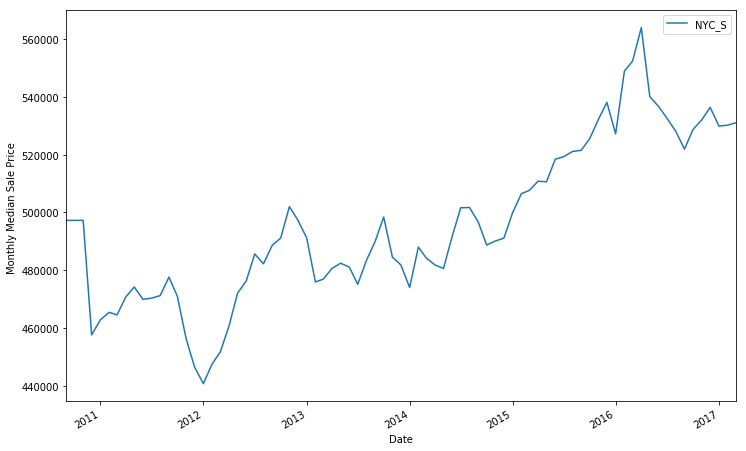

In [91]:
ax = df_ts_sale.set_index('index').plot(figsize=(12, 8))
ax.set_ylabel('Monthly Median Sale Price ')
ax.set_xlabel('Date')

plt.show()

In [92]:
nycs_model = Prophet(interval_width=0.95)


In [93]:
df_ts_sale = df_ts_sale.rename(columns={'index': 'ds',
                        'NYC_S': 'y'})

df_ts_sale.head(5)

,y,ds
0,497241.772152,2010-09-01
1,497241.772152,2010-10-01
2,497241.772152,2010-11-01
3,457600.000000,2010-12-01
4,462800.000000,2011-01-01


In [94]:
nycs_model.fit(df_ts_sale)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [95]:
future_dates = nycs_model.make_future_dataframe(periods=60, freq='MS')
future_dates.tail()

,ds
137,2021-11-01
138,2021-12-01
139,2022-01-01
140,2022-02-01
141,2022-03-01


In [96]:
forecast = nycs_model.predict(future_dates)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
137,2021-11-01,571568.680009,501666.885705,651595.851083
138,2021-12-01,566301.715317,490712.400487,646833.164312
139,2022-01-01,561490.596896,482712.540515,649750.172856
140,2022-02-01,562717.743180,482634.822117,648713.426692
141,2022-03-01,566100.586709,481736.866449,657962.689902


In [99]:
from fbprophet.diagnostics import cross_validation
future_dates = cross_validation(nycs_model, initial='730 days', period='60 days', horizon = '365 days')
future_dates.head()

INFO:fbprophet:Making 22 forecasts with cutoffs between 2012-09-18 00:00:00 and 2016-03-01 00:00:00
INFO:fbprophet:n_changepoints greater than number of observations.Using 19.
INFO:fbprophet:n_changepoints greater than number of observations.Using 20.
INFO:fbprophet:n_changepoints greater than number of observations.Using 22.
INFO:fbprophet:n_changepoints greater than number of observations.Using 23.


,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2012-10-01,508872.324693,507560.592613,510170.065719,491100.0,2012-09-18
1,2012-11-01,553124.543114,549179.923590,556870.403141,502000.0,2012-09-18
2,2012-12-01,462737.817325,455422.684365,469891.101910,497300.0,2012-09-18
3,2013-01-01,496976.182780,486665.963044,507219.789734,491200.0,2012-09-18
4,2013-02-01,499762.201068,484909.577858,514220.100683,475900.0,2012-09-18


In [104]:
from fbprophet.diagnostics import performance_metrics
df_p = performance_metrics(future_dates)
df_p.head()

,horizon,mse,rmse,mae,mape,coverage
0,45 days,5.994369e+08,24483.399904,19359.539213,0.038564,0.296296
1,46 days,6.152367e+08,24803.966313,19710.489211,0.039348,0.296296
2,48 days,4.037922e+08,20094.582253,17421.015424,0.034761,0.296296
3,49 days,3.969989e+08,19924.830951,17154.286350,0.034190,0.333333
4,50 days,3.941883e+08,19854.176607,16993.869038,0.033872,0.370370


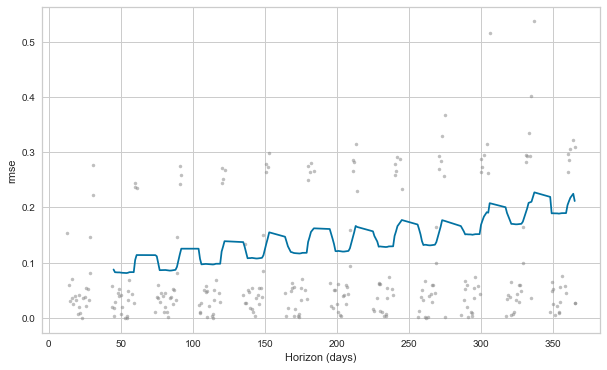

In [337]:
from fbprophet.plot import plot_cross_validation_metric
fig = plot_cross_validation_metric(future_dates, metric='rmse')

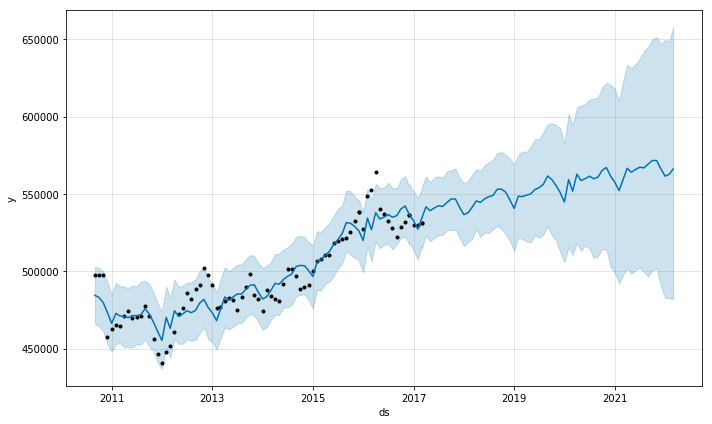

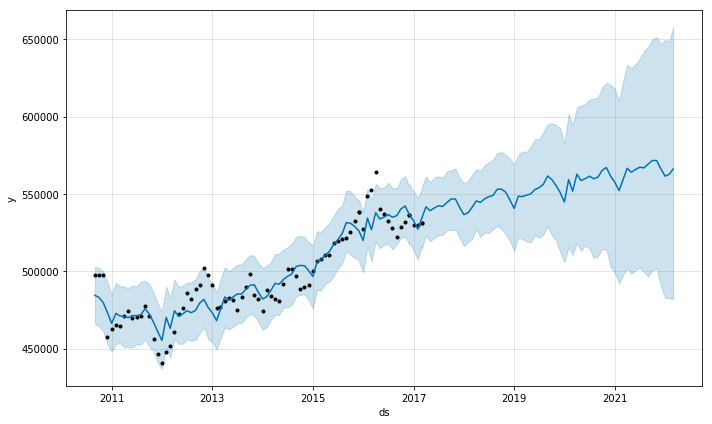

In [105]:
nycs_model.plot(forecast,
              uncertainty=True)

### Boston Sale projections:

In [106]:
df_bossale = df_final[['Boston_S', 'index']]

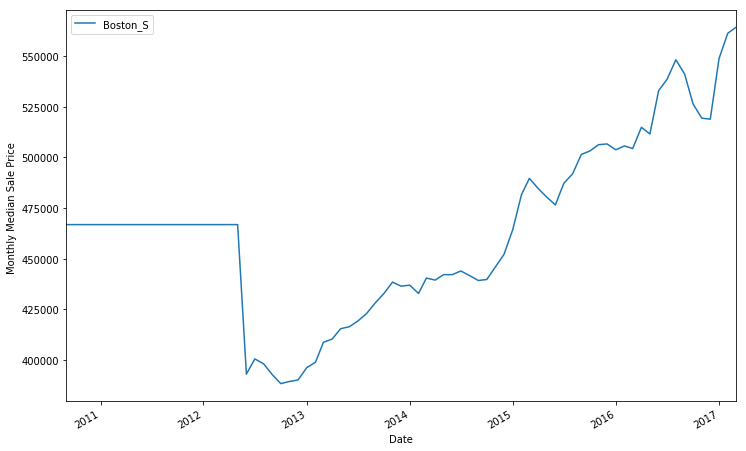

In [107]:
ax = df_bossale.set_index('index').plot(figsize=(12, 8))
ax.set_ylabel('Monthly Median Sale Price ')
ax.set_xlabel('Date')

plt.show()

In [108]:
boss_model = Prophet(interval_width=0.95)


In [109]:
df_bossale = df_bossale.rename(columns={'index': 'ds',
                        'Boston_S': 'y'})

df_bossale.head(5)

,y,ds
0,466878.688525,2010-09-01
1,466878.688525,2010-10-01
2,466878.688525,2010-11-01
3,466878.688525,2010-12-01
4,466878.688525,2011-01-01


In [110]:
boss_model.fit(df_bossale)


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [111]:
future_dates = boss_model.make_future_dataframe(periods=60, freq='MS')
future_dates.tail()

,ds
137,2021-11-01
138,2021-12-01
139,2022-01-01
140,2022-02-01
141,2022-03-01


In [112]:
forecast = boss_model.predict(future_dates)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
137,2021-11-01,734492.438943,570750.880488,898525.409940
138,2021-12-01,733662.221787,559611.080347,898252.229626
139,2022-01-01,746649.988542,573380.047256,914735.671157
140,2022-02-01,752012.772656,575527.883412,922775.395884
141,2022-03-01,758259.071859,579427.476050,939430.831165


In [119]:
from fbprophet.diagnostics import cross_validation
future_dates = cross_validation(boss_model, initial='730 days', period='60 days', horizon = '365 days')
future_dates.head()

INFO:fbprophet:Making 22 forecasts with cutoffs between 2012-09-18 00:00:00 and 2016-03-01 00:00:00
INFO:fbprophet:n_changepoints greater than number of observations.Using 19.
INFO:fbprophet:n_changepoints greater than number of observations.Using 20.
INFO:fbprophet:n_changepoints greater than number of observations.Using 22.
INFO:fbprophet:n_changepoints greater than number of observations.Using 23.


,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2012-10-01,380468.930531,379091.387387,381593.365483,388400.0,2012-09-18
1,2012-11-01,363859.262593,359938.041361,366962.777484,389500.0,2012-09-18
2,2012-12-01,345741.543474,338217.131455,351808.203176,390200.0,2012-09-18
3,2013-01-01,327344.274389,316360.545061,337088.981597,396300.0,2012-09-18
4,2013-02-01,308451.756963,293634.726207,322438.383353,399000.0,2012-09-18


In [336]:
from fbprophet.diagnostics import performance_metrics
df_p = performance_metrics(future_dates)
df_p.head(50)

,horizon,mse,rmse,mae,mape,coverage
0,45 days,0.007707,0.087791,0.058779,0.350729,0.814815
1,46 days,0.006864,0.082852,0.054148,0.326913,0.851852
2,48 days,0.006805,0.082491,0.053585,0.333899,0.851852
3,49 days,0.006815,0.082553,0.053891,0.352882,0.851852
4,50 days,0.006741,0.082103,0.052763,0.349640,0.851852
5,51 days,0.006699,0.081845,0.052061,0.341842,0.851852
6,53 days,0.006660,0.081608,0.050893,0.328866,0.851852
7,54 days,0.006620,0.081365,0.049669,0.312979,0.851852
8,55 days,0.006706,0.081889,0.051195,0.320508,0.851852
9,56 days,0.006879,0.082940,0.053700,0.339681,0.814815


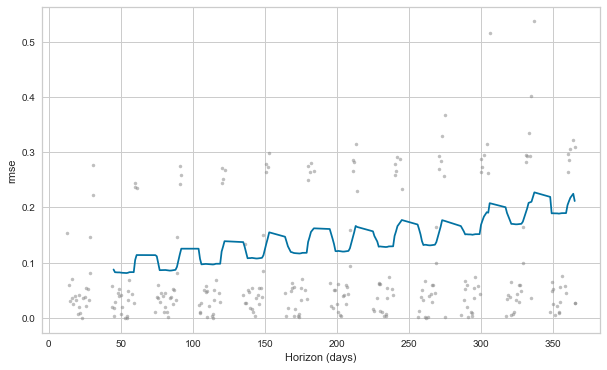

In [335]:
from fbprophet.plot import plot_cross_validation_metric
fig = plot_cross_validation_metric(future_dates, metric='rmse')

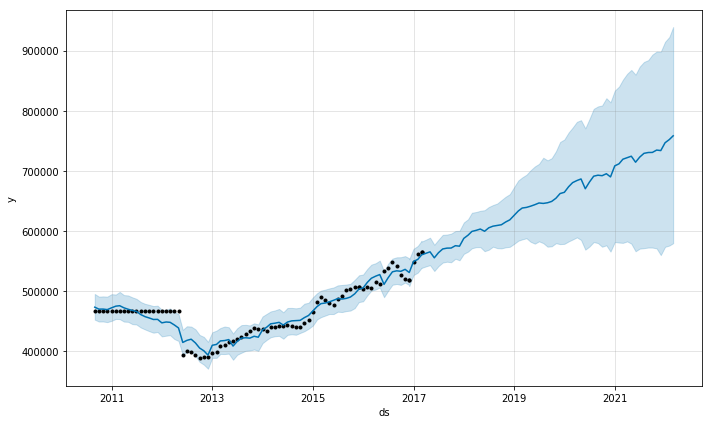

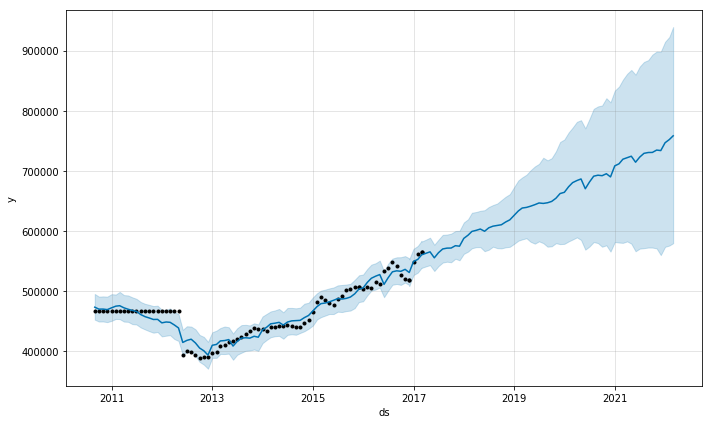

In [116]:
boss_model.plot(forecast,
              uncertainty=True)



### NYC Rental projections:

In [125]:
df_nycrent = df_final[['NYC_R', 'index']]

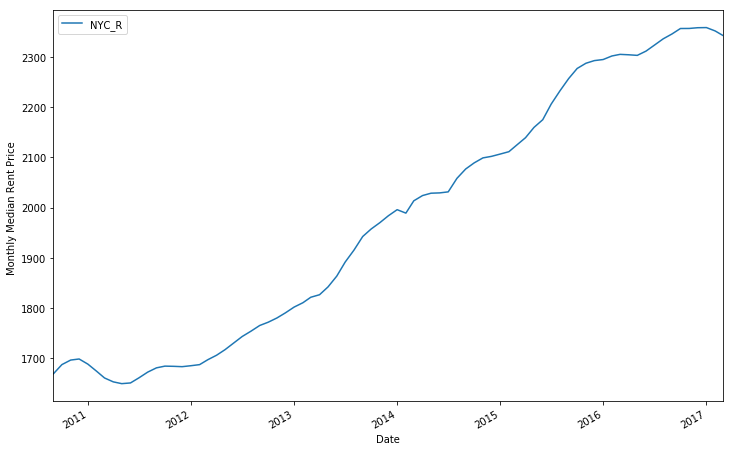

In [126]:
ax = df_nycrent.set_index('index').plot(figsize=(12, 8))
ax.set_ylabel('Monthly Median Rent Price ')
ax.set_xlabel('Date')

plt.show()

In [127]:
nycr_model = Prophet(interval_width=0.95)


In [128]:
df_nycrent = df_nycrent.rename(columns={'index': 'ds',
                        'NYC_R': 'y'})

df_nycrent.head(5)

,y,ds
0,1668.64,2010-09-01
1,1686.88,2010-10-01
2,1695.90,2010-11-01
3,1698.04,2010-12-01
4,1687.80,2011-01-01


In [129]:
nycr_model.fit(df_nycrent)


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [130]:
future_dates = nycr_model.make_future_dataframe(periods=60, freq='MS')
future_dates.tail()

,ds
137,2021-11-01
138,2021-12-01
139,2022-01-01
140,2022-02-01
141,2022-03-01


In [131]:
forecast = nycr_model.predict(future_dates)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
137,2021-11-01,2620.708086,1277.685520,3977.601152
138,2021-12-01,2620.163012,1239.893757,4016.185602
139,2022-01-01,2619.967045,1200.205328,4062.728934
140,2022-02-01,2614.096471,1149.911423,4104.775959
141,2022-03-01,2617.200850,1110.052664,4137.651276


In [132]:
from fbprophet.diagnostics import cross_validation
future_dates = cross_validation(nycr_model, initial='730 days', period='60 days', horizon = '365 days')
future_dates.head()

INFO:fbprophet:Making 22 forecasts with cutoffs between 2012-09-18 00:00:00 and 2016-03-01 00:00:00
INFO:fbprophet:n_changepoints greater than number of observations.Using 19.
INFO:fbprophet:n_changepoints greater than number of observations.Using 20.
INFO:fbprophet:n_changepoints greater than number of observations.Using 22.
INFO:fbprophet:n_changepoints greater than number of observations.Using 23.


,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2012-10-01,1841.407513,1836.013140,1846.103811,1771.34,2012-09-18
1,2012-11-01,1865.928160,1851.079053,1879.611878,1779.81,2012-09-18
2,2012-12-01,1862.213421,1835.418899,1888.404342,1789.98,2012-09-18
3,2013-01-01,1838.214145,1796.393346,1877.721854,1801.54,2012-09-18
4,2013-02-01,1838.831024,1780.510633,1892.142571,1810.17,2012-09-18


In [133]:
from fbprophet.diagnostics import performance_metrics
df_p = performance_metrics(future_dates)
df_p.head(50)

,horizon,mse,rmse,mae,mape,coverage
0,45 days,654.965178,25.592287,15.727011,0.008323,0.444444
1,46 days,485.307646,22.029699,13.803405,0.007213,0.481481
2,48 days,468.289608,21.640000,13.303557,0.006917,0.518519
3,49 days,460.532757,21.460027,12.857243,0.006655,0.592593
4,50 days,483.794979,21.995340,13.490807,0.006945,0.592593


In [ ]:
from fbprophet.plot import plot_cross_validation_metric
fig = plot_cross_validation_metric(future_dates, metric='rmse')

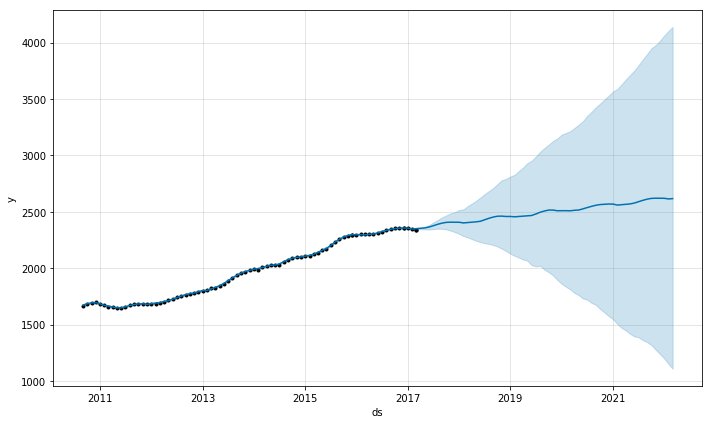

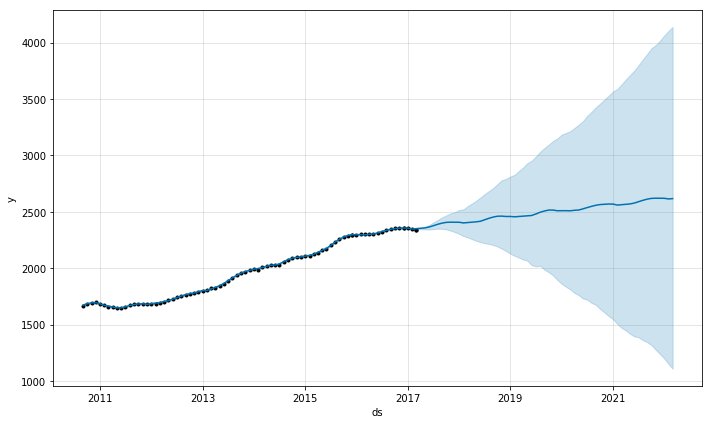

In [134]:
nycr_model.plot(forecast,
              uncertainty=True)

### Boston Rental projections:

In [135]:
df_bosrent = df_final[['Boston_R', 'index']]

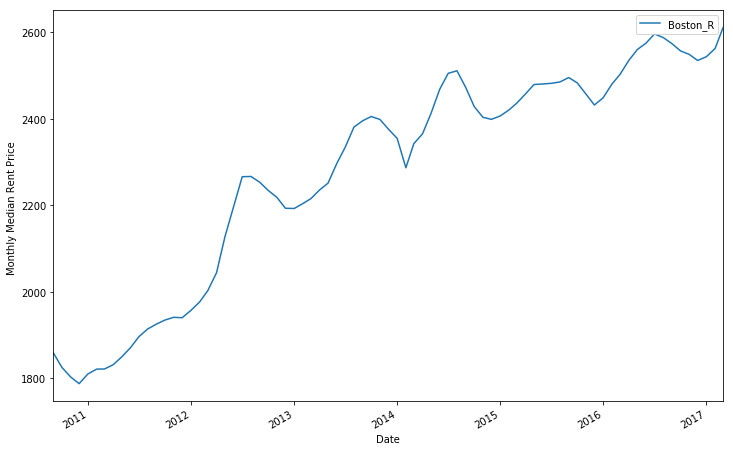

In [136]:
ax = df_bosrent.set_index('index').plot(figsize=(12, 8))
ax.set_ylabel('Monthly Median Rent Price ')
ax.set_xlabel('Date')

plt.show()

In [137]:
bosr_model = Prophet(interval_width=0.95)


In [138]:
df_bosrent = df_bosrent.rename(columns={'index': 'ds',
                        'Boston_R': 'y'})

df_bosrent.head(5)

,y,ds
0,1857.87,2010-09-01
1,1824.65,2010-10-01
2,1802.43,2010-11-01
3,1787.04,2010-12-01
4,1809.40,2011-01-01


In [139]:
bosr_model.fit(df_bosrent)


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [140]:
future_dates = bosr_model.make_future_dataframe(periods=60, freq='MS')
future_dates.tail()

,ds
137,2021-11-01
138,2021-12-01
139,2022-01-01
140,2022-02-01
141,2022-03-01


In [141]:
forecast = bosr_model.predict(future_dates)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
137,2021-11-01,3029.252346,2278.286190,3697.291726
138,2021-12-01,3009.112905,2265.738791,3698.807803
139,2022-01-01,3016.846802,2246.575665,3748.103831
140,2022-02-01,3017.838008,2227.923718,3751.479823
141,2022-03-01,3046.472759,2233.362758,3805.069945


In [142]:
from fbprophet.diagnostics import cross_validation
future_dates = cross_validation(bosr_model, initial='730 days', period='60 days', horizon = '365 days')
future_dates.head()

INFO:fbprophet:Making 22 forecasts with cutoffs between 2012-09-18 00:00:00 and 2016-03-01 00:00:00
INFO:fbprophet:n_changepoints greater than number of observations.Using 19.
INFO:fbprophet:n_changepoints greater than number of observations.Using 20.
INFO:fbprophet:n_changepoints greater than number of observations.Using 22.
INFO:fbprophet:n_changepoints greater than number of observations.Using 23.


,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2012-10-01,2191.390813,2183.486437,2203.181718,2234.08,2012-09-18
1,2012-11-01,2171.252776,2146.556168,2200.245484,2217.84,2012-09-18
2,2012-12-01,2194.837893,2150.327915,2246.102026,2192.73,2012-09-18
3,2013-01-01,2298.817926,2231.527557,2375.080638,2192.16,2012-09-18
4,2013-02-01,2377.496496,2281.681843,2480.431147,2203.64,2012-09-18


In [143]:
from fbprophet.diagnostics import performance_metrics
df_p = performance_metrics(future_dates)
df_p.head(50)

,horizon,mse,rmse,mae,mape,coverage
0,45 days,2593.959175,50.930926,40.153748,0.017161,0.444444
1,46 days,2636.620371,51.348032,40.592534,0.017319,0.444444
2,48 days,2845.160127,53.340042,42.968696,0.018294,0.444444
3,49 days,2941.207958,54.232905,44.144266,0.018734,0.407407
4,50 days,2955.105691,54.360884,43.150578,0.018280,0.444444


In [ ]:
from fbprophet.plot import plot_cross_validation_metric
fig = plot_cross_validation_metric(future_dates, metric='rmse')

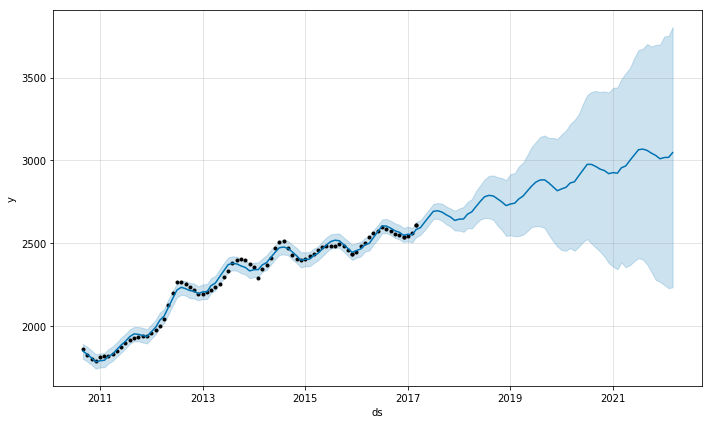

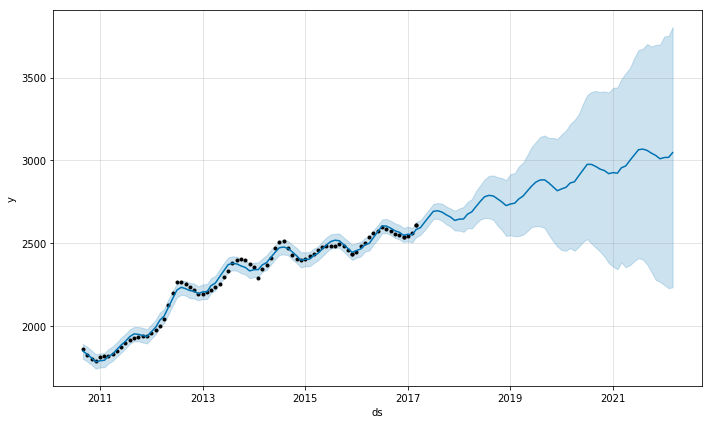

In [144]:
bosr_model.plot(forecast,
              uncertainty=True)

### Unemployment Rate projections:


In [145]:
unemployment_ = df_final[[ 'Unemployment Rate', 'index']]

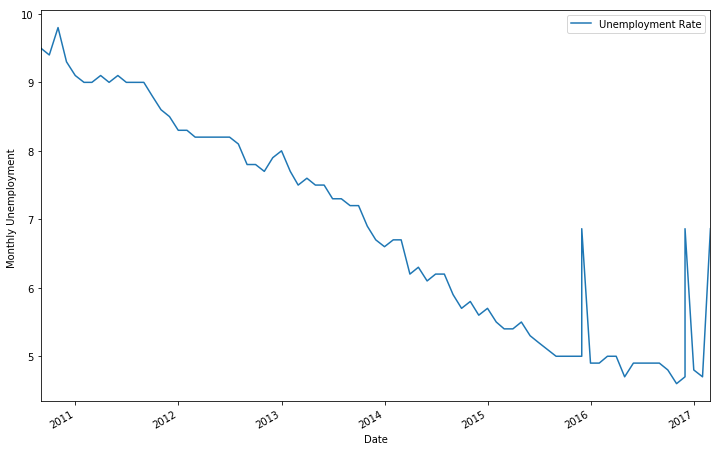

In [146]:
ax = unemployment_.set_index('index').plot(figsize=(12, 8))
ax.set_ylabel('Monthly Unemployment ')
ax.set_xlabel('Date')

plt.show()

In [147]:
unemployment_model = Prophet(interval_width=0.95)

In [148]:
unemployment_ = unemployment_.rename(columns={'index': 'ds',
                        'Unemployment Rate': 'y'})

unemployment_.head(5)

,y,ds
0,9.5,2010-09-01
1,9.4,2010-10-01
2,9.8,2010-11-01
3,9.3,2010-12-01
4,9.1,2011-01-01


In [149]:
unemployment_model.fit(unemployment_)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [150]:
future_dates = unemployment_model.make_future_dataframe(periods=60, freq='MS')
future_dates.tail()

,ds
137,2021-11-01
138,2021-12-01
139,2022-01-01
140,2022-02-01
141,2022-03-01


In [151]:
forecast = unemployment_model.predict(future_dates)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
137,2021-11-01,4.476919,3.218011,5.775219
138,2021-12-01,4.874050,3.595060,6.332359
139,2022-01-01,4.486836,3.161896,5.784007
140,2022-02-01,4.410625,3.113638,5.793774
141,2022-03-01,4.891300,3.516671,6.288792


In [152]:
from fbprophet.diagnostics import cross_validation
future_dates = cross_validation(unemployment_model, initial='730 days', period='60 days', horizon = '365 days')
future_dates.head()

INFO:fbprophet:Making 22 forecasts with cutoffs between 2012-09-18 00:00:00 and 2016-03-01 00:00:00
INFO:fbprophet:n_changepoints greater than number of observations.Using 19.
INFO:fbprophet:n_changepoints greater than number of observations.Using 20.
INFO:fbprophet:n_changepoints greater than number of observations.Using 22.
INFO:fbprophet:n_changepoints greater than number of observations.Using 23.


,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2012-10-01,7.756808,7.730174,7.782999,7.8,2012-09-18
1,2012-11-01,9.327882,9.254257,9.400210,7.7,2012-09-18
2,2012-12-01,8.023899,7.896102,8.155004,7.9,2012-09-18
3,2013-01-01,7.722356,7.524691,7.923977,8.0,2012-09-18
4,2013-02-01,7.255563,6.976714,7.537439,7.7,2012-09-18


In [153]:
from fbprophet.diagnostics import performance_metrics
df_p = performance_metrics(future_dates)
df_p.head(50)

,horizon,mse,rmse,mae,mape,coverage
0,45 days,0.350155,0.591739,0.342137,0.051091,0.592593
1,46 days,0.354482,0.595384,0.353298,0.052634,0.592593
2,48 days,0.353063,0.594191,0.346880,0.051833,0.629630
3,49 days,0.342751,0.585449,0.345062,0.051901,0.574074
4,50 days,0.333886,0.577829,0.341827,0.051950,0.555556


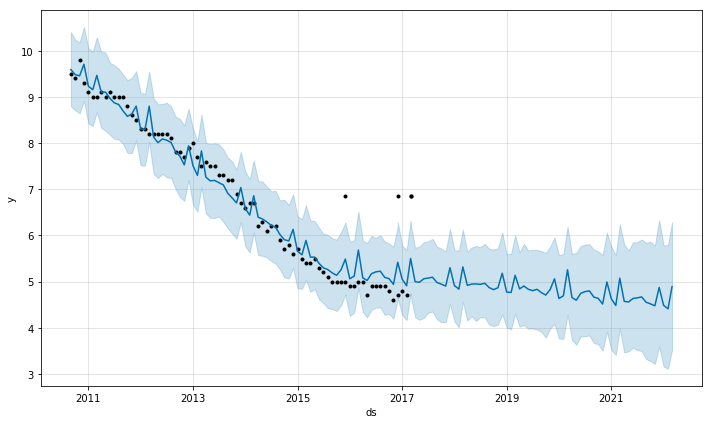

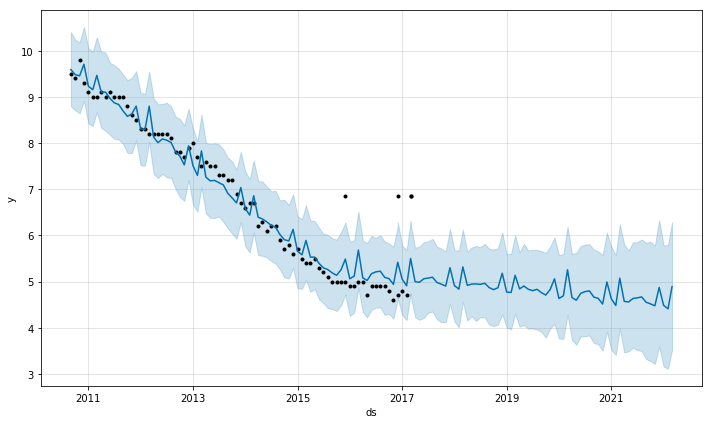

In [154]:
unemployment_model.plot(forecast,
              uncertainty=True)

### Interest Rate projections:

In [155]:
interestrate = df_final[[ 'Effective Federal Funds Rate', 'index']] 

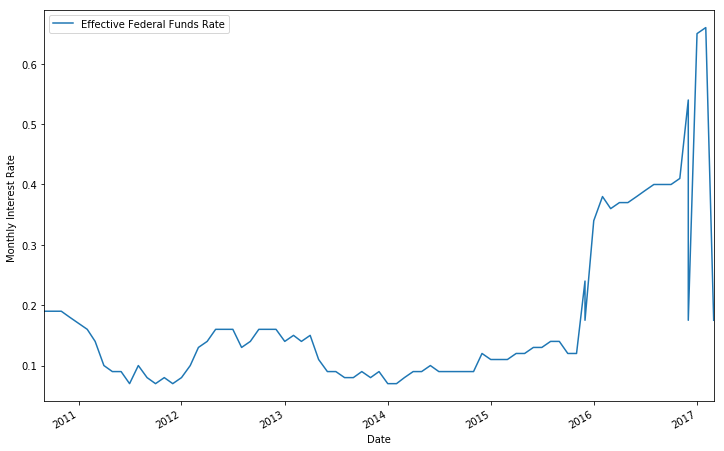

In [156]:
ax = interestrate.set_index('index').plot(figsize=(12, 8))
ax.set_ylabel('Monthly Interest Rate ')
ax.set_xlabel('Date')

plt.show()

In [157]:
ir_model = Prophet(interval_width=0.95)

In [158]:
interestrate = interestrate.rename(columns={'index': 'ds',
                        'Effective Federal Funds Rate': 'y'})

interestrate.head(5)

,y,ds
0,0.19,2010-09-01
1,0.19,2010-10-01
2,0.19,2010-11-01
3,0.18,2010-12-01
4,0.17,2011-01-01


In [159]:
ir_model.fit(interestrate)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [160]:
future_dates = ir_model.make_future_dataframe(periods=60, freq='MS')
future_dates.tail()

,ds
137,2021-11-01
138,2021-12-01
139,2022-01-01
140,2022-02-01
141,2022-03-01


In [161]:
forecast = ir_model.predict(future_dates)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
137,2021-11-01,0.870416,0.667868,1.070960
138,2021-12-01,0.875070,0.681660,1.082891
139,2022-01-01,0.946892,0.741533,1.146918
140,2022-02-01,0.957357,0.753410,1.178542
141,2022-03-01,0.878754,0.692146,1.086516


In [162]:
from fbprophet.diagnostics import cross_validation
future_dates = cross_validation(ir_model, initial='730 days', period='60 days', horizon = '365 days')
future_dates.head()

INFO:fbprophet:Making 22 forecasts with cutoffs between 2012-09-18 00:00:00 and 2016-03-01 00:00:00
INFO:fbprophet:n_changepoints greater than number of observations.Using 19.
INFO:fbprophet:n_changepoints greater than number of observations.Using 20.
INFO:fbprophet:n_changepoints greater than number of observations.Using 22.
INFO:fbprophet:n_changepoints greater than number of observations.Using 23.


,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2012-10-01,0.006486,-0.066199,0.080989,0.16,2012-09-18
1,2012-11-01,0.102162,0.032121,0.171885,0.16,2012-09-18
2,2012-12-01,0.170566,0.100061,0.246493,0.16,2012-09-18
3,2013-01-01,0.148381,0.072967,0.217850,0.14,2012-09-18
4,2013-02-01,0.016329,-0.054876,0.084372,0.15,2012-09-18


In [163]:
from fbprophet.diagnostics import performance_metrics
df_p = performance_metrics(future_dates)
df_p.head()

,horizon,mse,rmse,mae,mape,coverage
0,45 days,0.007707,0.087791,0.058779,0.350729,0.814815
1,46 days,0.006864,0.082852,0.054148,0.326913,0.851852
2,48 days,0.006805,0.082491,0.053585,0.333899,0.851852
3,49 days,0.006815,0.082553,0.053891,0.352882,0.851852
4,50 days,0.006741,0.082103,0.052763,0.349640,0.851852


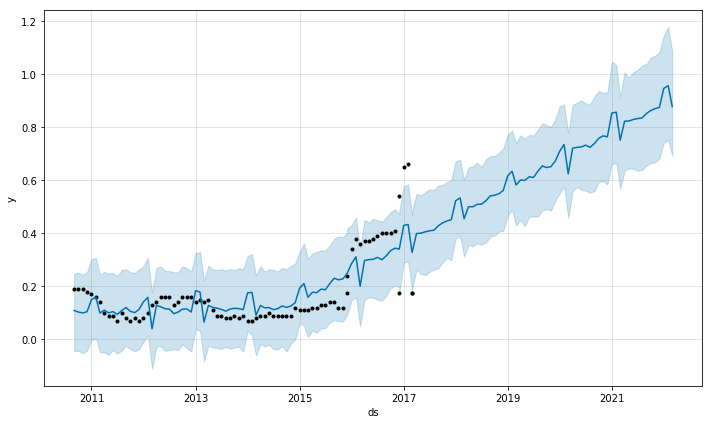

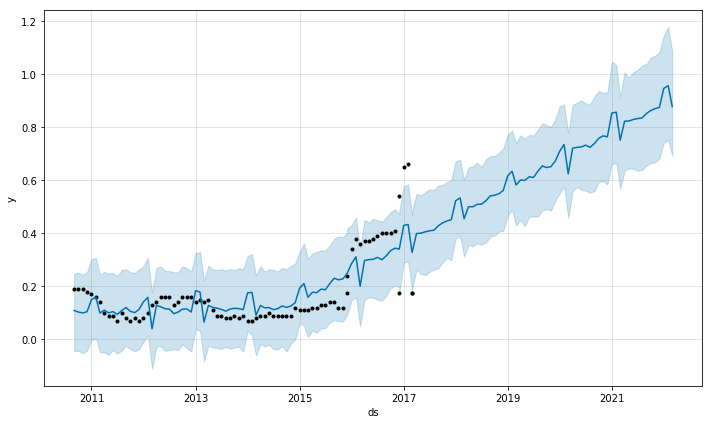

In [164]:
ir_model.plot(forecast,
              uncertainty=True)

# Demo section. Load the best model I have. Even if its OLS load prediction vs real one and show it

Bushwick 2 bed rental: https://www.zillow.com/homedetails/183-Stanhope-St-APT-1L-Brooklyn-NY-11237/2124261600_zpid/?

Bushwick 2 bed sale: https://www.zillow.com/homedetails/68-Garden-St-APT-7K-Brooklyn-NY-11206/2089555369_zpid/?


# Unsupervised Modeling! 

## Now we will use unsupervised models to try and help us find clusters of areas and times of the year that would be optimal for examinging in the potential years to come. 

### Let's create a couple of new columns labeled Month and Year so that we can use those features in our clustering.


In [252]:

X2 = df_final[[ 'Month', 'Year', 'MA_S', 'MA_R', 'MA_SqF', 'NY_days', 'MA_days', 'Boston_S', 'NYC_S', 'Boston_R', 'NYC_R']] 

## K means worked best for me when I was trying various clustering algorithms, so we be using K means for our unsupervised analysis:

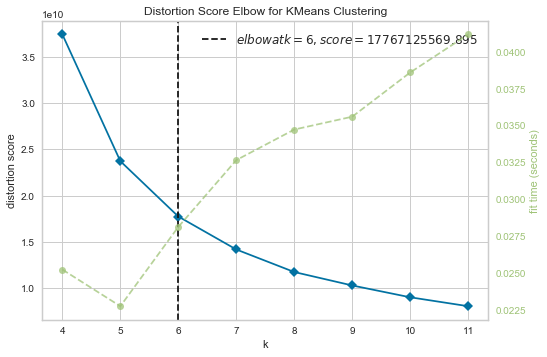

In [253]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer

# Instantiate the clustering model and visualizer
scaler = StandardScaler(X2)
model = KMeans()
visualizer = KElbowVisualizer(model, k=(4,12))

visualizer.fit(X2)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

In [254]:
# Import KMeans
from sklearn.cluster import KMeans

model = KMeans(n_clusters=6)

# Fit model to points
model.fit(X2)

# Determine the cluster labels of new_points: labels
labels = model.predict(X2)

# Print cluster labels of new_points
print(labels)

[2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 4 4 4 4 4 4 4 4 4 1 1 1 1 1 1 1 1 1 1 5 5 5
 1 1 1 1 5 5 5 5]


In [255]:
df_final['Label'] = labels 
print (df_final['Label'])

0     2
1     2
2     2
3     2
4     2
     ..
77    1
78    5
79    5
80    5
81    5
Name: Label, Length: 82, dtype: int32


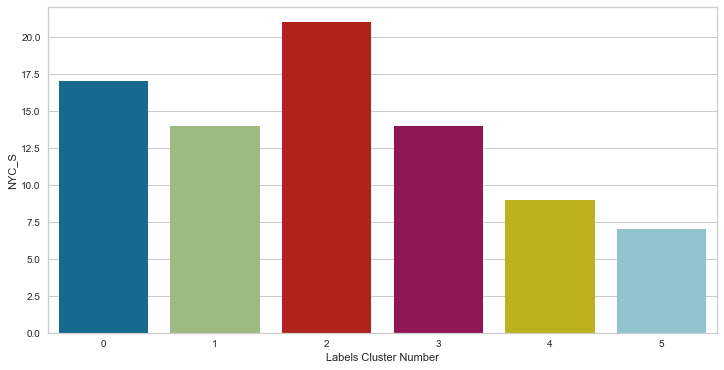

In [256]:

plt.figure(figsize=(12,6))
axis = sns.barplot(x= np.arange(0,6,1),y=df_final.groupby(['Label']).count()['NYC_S'].values)
x=axis.set_xlabel("Labels Cluster Number")
x=axis.set_ylabel("NYC_S")

In [257]:
from sklearn.metrics import silhouette_samples, silhouette_score

silhouette_avg = silhouette_score(X2, labels)
print("The average silhouette_score is :", silhouette_avg)

The average silhouette_score is : 0.5356139459156293


## Here I am creating a new df so that we can use the cluster labels in our analysis

In [258]:

X3 = df_final[['NY_S', 'Label', 'Month', 'Year', 'MA_S', 'NY_R', 'MA_R', 'NY_SqF', 'MA_SqF', 'NY_days', 'MA_days', 'Boston_S', 'NYC_S', 'Boston_R', 'NYC_R']] 



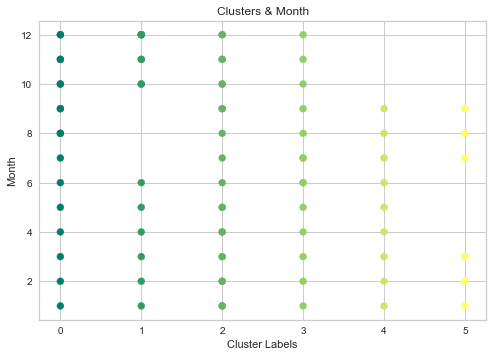

In [259]:
plt.scatter(X3['Label'], X3['Month'], c = labels, cmap = 'summer' )
plt.title("Clusters & Month")
plt.xlabel("Cluster Labels")
plt.ylabel("Month")
plt.show()

### Clustering is able to help us us groupings of certain months regarding the various cluster labels. Though we see a wide distribution among the various clusters, we do see that cluster 4 and 5 are limited in the number of months that are included in those clusters. This would indicate those cluster groupings might include average listings that are favor the spring and summer. 

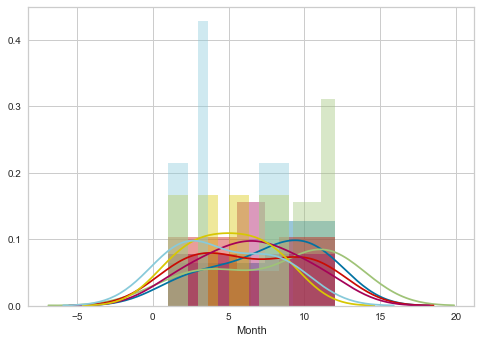

In [260]:


for i in range(7): 
    sns.distplot(df_final[df_final['Label'] == i]['Month'], bins=12)
    

In [261]:
df_final['Month'] = df_final['Month'].astype(str)

In [262]:
df_final[df_final['Label'] == 0]['Month'].astype(int).value_counts()

12    2
11    2
10    2
9     2
8     2
7     1
6     1
5     1
4     1
3     1
2     1
1     1
Name: Month, dtype: int64

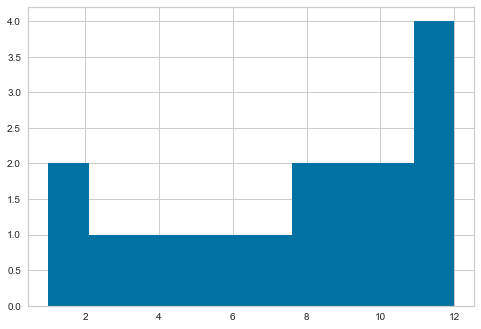

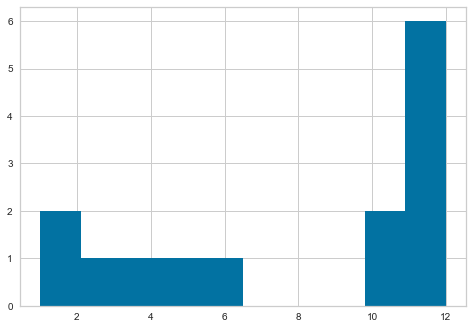

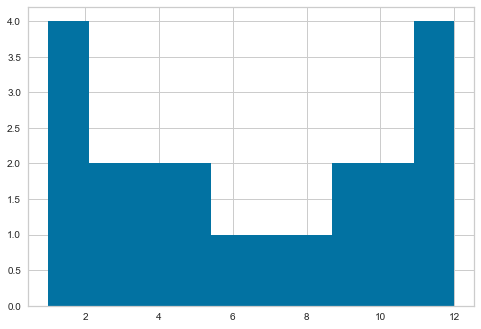

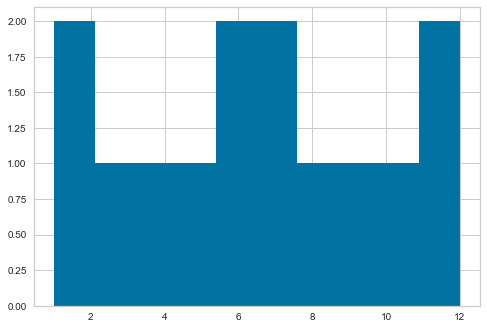

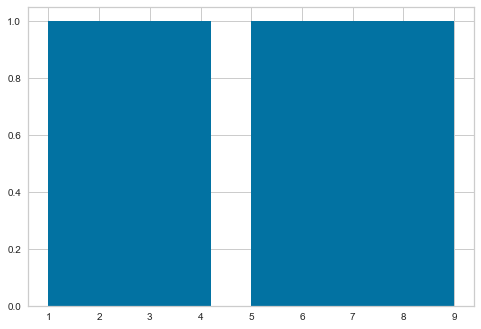

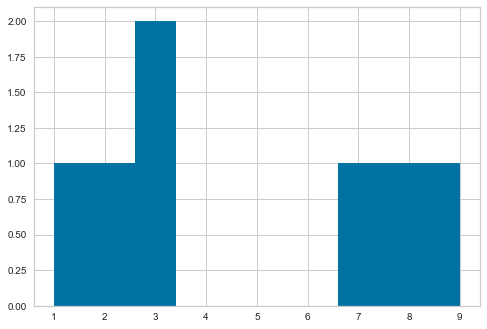

In [263]:
for i in range(6): 
    df_final[df_final['Label'] == i]['Month'].astype(int).hist()    
    plt.show()

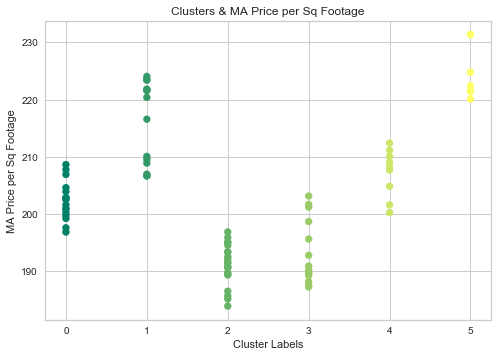

In [266]:
plt.scatter(X3['Label'], X3['MA_SqF'], c = labels, cmap = 'summer' )
plt.title("Clusters & MA Price per Sq Footage")
plt.xlabel("Cluster Labels")
plt.ylabel("MA Price per Sq Footage")
plt.show()

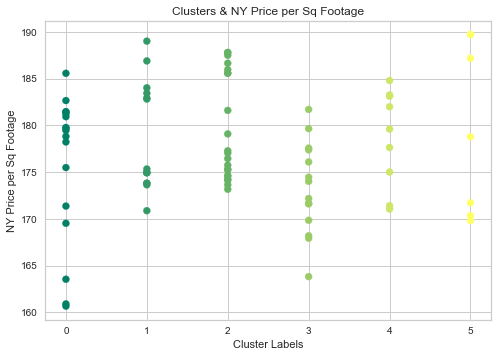

In [267]:
plt.scatter(X3['Label'], X3['NY_SqF'], c = labels, cmap = 'summer' )
plt.title("Clusters & NY Price per Sq Footage")
plt.xlabel("Cluster Labels")
plt.ylabel("NY Price per Sq Footage")
plt.show()

### Here we also see cluster groupings which have square footage densities that favor certain clusters. For instance, cluster 1 and cluster 5 favor higher price per square footage in both MA and NY, while cluster 3 seems to include listings lower on that spectrum. Let's see if we see patterns between days on the market. 

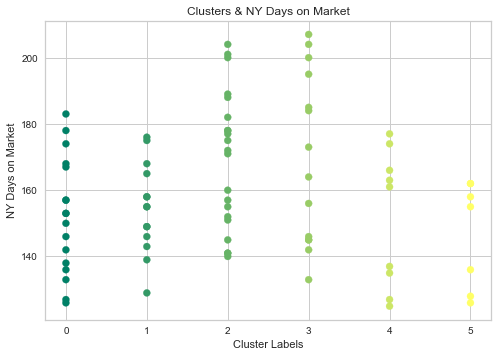

In [268]:
plt.scatter(X3['Label'], X3['NY_days'], c = labels, cmap = 'summer' )
plt.title("Clusters & NY Days on Market")
plt.xlabel("Cluster Labels")
plt.ylabel("NY Days on Market")
plt.show()

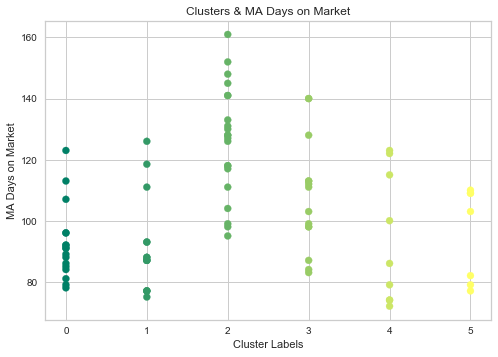

In [269]:
plt.scatter(X3['Label'], X3['MA_days'], c = labels, cmap = 'summer' )
plt.title("Clusters & MA Days on Market")
plt.xlabel("Cluster Labels")
plt.ylabel("MA Days on Market")
plt.show()

### Here we can also see certain preferences between the clusters. Namely, cluster 2 contains the higher end of listings with a larger number of days on the market. Clusters 4 and 5 seem to have a lower number of instances with lower days on the market. 

# Let's now turn our attention to our original Y targets from our supervised learning portion: NYC and Boston sale and rent numbers for our last bit of insight regarding clusters.

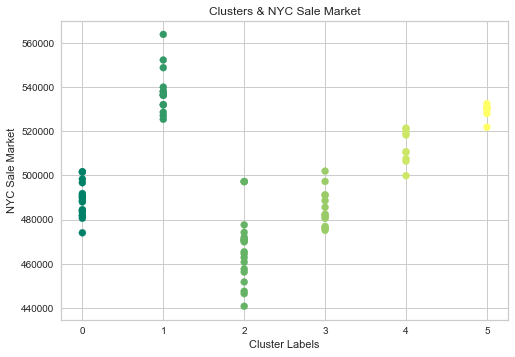

In [270]:
plt.scatter(X3['Label'], X3['NYC_S'], c = labels, cmap = 'summer' )
plt.title("Clusters & NYC Sale Market")
plt.xlabel("Cluster Labels")
plt.ylabel("NYC Sale Market")
plt.show()

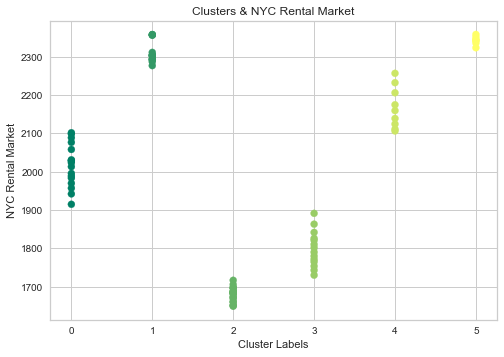

In [271]:
plt.scatter(X3['Label'], X3['NYC_R'], c = labels, cmap = 'summer' )
plt.title("Clusters & NYC Rental Market")
plt.xlabel("Cluster Labels")
plt.ylabel("NYC Rental Market")
plt.show()

### Regarding the NYC rent and sale market, clusters 1 and 5 include median values that are on the higher end of the spectrum and clusters 0 and 2 include median values that are on the lower end of the spectrum. We can pair this data with the days on the market and price per square footage data to come up with some cluster profiles.

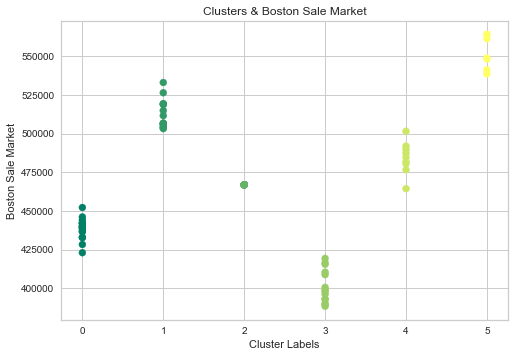

In [272]:
plt.scatter(X3['Label'], X3['Boston_S'], c = labels, cmap = 'summer' )
plt.title("Clusters & Boston Sale Market")
plt.xlabel("Cluster Labels")
plt.ylabel("Boston Sale Market")
plt.show()

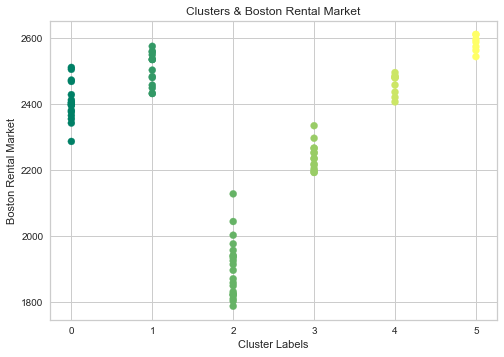

In [273]:
plt.scatter(X3['Label'], X3['Boston_R'], c = labels, cmap = 'summer' )
plt.title("Clusters & Boston Rental Market")
plt.xlabel("Cluster Labels")
plt.ylabel("Boston Rental Market")
plt.show()

### Regarding Boston rent and sale prices, cluster 1 and 5 also include the higher end of the spectrum, while clusters 0 and 2 include the lower end of the spectrum. We can pair this data with the days on the market and price per square footage data to come up with some cluster profiles.

## The clustering can help us with creating profiles on certain trends within the greater analysis of the Boston and NYC markets, while the regression models, along with prophet, can help us with being able to predict potential prices in the future. 

# A great next step from here would be to take a look and see where we can make greater efficiencies so that we can truly create a seamless recommender for folks looking to plan their future lives. Using machine learning to understand the market and where a market might be headed in the future is a great way to make data driven solutions for the future! 